# Uncovering Healthcare Inefficiencies - Model Building and Evaluation

This notebook focuses on building, training, and evaluating various models to determine the best performing model for our dataset.

The models included in this notebook are:

1. **Logistic Regression**: Used as the baseline model.
2. **Ridge Classifier**: Classification model using L2 regularization.
3. **Lasso Classifier**: Classification model using L1 regularization.
4. **Extreme Gradient Boosting (XGBoost)**: Powerful gradient boosting framework.
5. **Quadratic Discriminant Analysis (QDA)**: A classification model that assumes different covariance matrices for each class.
6. **Neural Network**: Deep learning model that can capture complex patterns in data.
7. **Bagging Classifier**: Ensemble method that improves model stability and accuracy by combining multiple models.
8. **Support Vector Machine**: Classification model effective for high-dimensional data.
9. **AdaBoost**:Boosting method that combines multiple weak classifiers to form a strong classifier.


Each model undergoes the following steps:

1. **Data Preprocessing**: Standardizing and preparing data.
2. **Model Building**: Constructing model architecture.
3. **Model Training**: Training the model.
4. **Model Evaluation**: Assessing performance.
5. **Results Analysis**: Comparing results to determine the best model.


The objective is to identify the model that yields the best results in terms of accuracy and other relevant metrics. 

## Import Libaries

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import os
import ast

from scipy.cluster.hierarchy import linkage

from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.cluster import KMeans

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report, matthews_corrcoef, cohen_kappa_score,
    roc_curve, auc
)

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer

from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from scipy.stats import uniform, randint

import joblib

from sklearn.preprocessing import StandardScaler

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning) # suppress warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
# Check current working directory
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: /Users/samantharivas/Documents/UNIVERSITY OF SAN DIEGO/ADS599/healthcare-market-saturation-fraud


#### Import data from preprocessing notebook

In [3]:
# Read in data
# all the training/validation/test dataframes
x_train = pd.read_csv('data/x_train.csv') 
x_train_scaled = pd.read_csv('data/x_train_scaled.csv')
x_train_pca = pd.read_csv('data/x_train_pca.csv')
x_train_scaled_pca = pd.read_csv('data/x_train_scaled_pca.csv')

x_val = pd.read_csv('data/x_val.csv') 
x_val_scaled = pd.read_csv('data/x_val_scaled.csv')
x_val_pca = pd.read_csv('data/x_val_pca.csv')
x_val_scaled_pca = pd.read_csv('data/x_val_scaled_pca.csv')

x_test = pd.read_csv('data/x_test.csv')
x_test_scaled = pd.read_csv('data/x_test_scaled.csv')
x_test_pca = pd.read_csv('data/x_test_pca.csv')
x_test_scaled_pca = pd.read_csv('data/x_test_scaled_pca.csv')


# all the labels
y_train = np.ravel(pd.read_csv('data/y_train.csv'))
y_val = np.ravel(pd.read_csv('data/y_val.csv'))
y_test = np.ravel(pd.read_csv('data/y_test.csv'))

## DataTransformation 

### Yeo Johnson transformation of data

We wanted to add in additional dataframes to see if there was a difference in modeling performance. This Yeo-Johnson transformation was one of them, another would be to do transformation + scaling.

In [4]:
# transformed data
# create copy of df 
x_train_transformed = x_train.copy()
x_val_transformed = x_val.copy()
x_test_transformed = x_test.copy()

# get numeric columns
numeric_columns = x_train_transformed.select_dtypes(include=['float']).columns

def yeo_johnson_transform(column):
    # Create an instance of PowerTransformer with Yeo-Johnson method
    pt = PowerTransformer(method='yeo-johnson')
    
    # Reshape column for PowerTransformer which expects 2D input
    column_reshaped = column.values.reshape(-1, 1)
    
    # Fit and transform the column
    transformed_col = pt.fit_transform(column_reshaped)
    
    # Flatten the result to match original column shape
    return transformed_col.flatten()

# Apply Box-Cox transformation to each numeric column
for col in numeric_columns:
    x_train_transformed[col] = yeo_johnson_transform(x_train_transformed[col])
    x_val_transformed[col] = yeo_johnson_transform(x_val_transformed[col])
    x_test_transformed[col] = yeo_johnson_transform(x_test_transformed[col])


### Log transformed + scaled data

In [5]:
x_train_trans_scaled = x_train_transformed.copy()
x_val_trans_scaled = x_val_transformed.copy()
x_test_trans_scaled = x_test_transformed.copy()

scaler = RobustScaler()
x_train_trans_scaled[numeric_columns] = scaler.fit_transform(x_train_trans_scaled[numeric_columns])
x_val_trans_scaled[numeric_columns] = scaler.transform(x_val_trans_scaled[numeric_columns])
x_test_trans_scaled[numeric_columns] = scaler.transform(x_test_trans_scaled[numeric_columns])

### Cross Validation 

In [6]:
# define cross-validation strategy
def evaluate_model(model, X, y):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    accuracy_scores = []

    fold_results = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        else:
            X_train, X_test = X[train_index], X[test_index]
        
        if isinstance(y, (pd.Series, pd.DataFrame)):
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        else:
            y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        fold_results.append({
            'fold': fold,
            'accuracy': accuracy
        })

    print("\nIndividual Fold Results:")
    for result in fold_results:
        print(f"Fold {result['fold']}: Accuracy: {result['accuracy']:.4f}")

    mean_score = np.mean(accuracy_scores)
    std_score = np.std(accuracy_scores)

    return mean_score, std_score

## Baseline Model Selection - Logistic Regression

We'll first start by deciding on a baseline model for comparison against other models. The confusion matrix will be used to determine which dataframe will be ingested for each machine learning model. We currently have the following dataframes/data to feed into the logistic regression model:

* The preprocessed data - x_train
* The transformed data - x_train_tranformed
* The scaled data - x_train_scaled
* The transformed + scaled data - x_train_trans_scaled
* The pca transformed data - x_train_pca
* The scaled data + pca - x_train_scaled_pca

Based on the results of the baseline regression model, we can choose a dataframe to carry through the modeling process.

### Create and train Logistic Regression Model for unscaled data

This is the first model with the data that has been preprocessed but not scaled nor transformed for normality. The accuracy was terrible, the precision and F-score were non existant.

In [7]:
# logreg model
logreg_model = LogisticRegression(random_state = 42)

# Train the model
logreg_model.fit(x_train, y_train)

# Evaluate the model on the validation set
y_val_pred = logreg_model.predict(x_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_confusion_matrix = confusion_matrix(y_val, y_val_pred)
val_classification_report = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {val_accuracy}')
print('Validation Confusion Matrix:')
print(val_confusion_matrix)
print('Validation Classification Report:')
print(val_classification_report)


# Evaluate the model on the test set
y_test_pred = logreg_model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy}')
print('Test Confusion Matrix:')
print(test_confusion_matrix)
print('Test Classification Report:')
print(test_classification_report)

Validation Accuracy: 0.6181815860532515
Validation Confusion Matrix:
[[59423 57408]
 [ 2405 37417]]
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.51      0.67    116831
           1       0.39      0.94      0.56     39822

    accuracy                           0.62    156653
   macro avg       0.68      0.72      0.61    156653
weighted avg       0.82      0.62      0.64    156653

Test Accuracy: 0.6179414505853664
Test Confusion Matrix:
[[59410 57422]
 [ 2429 37393]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.51      0.67    116832
           1       0.39      0.94      0.56     39822

    accuracy                           0.62    156654
   macro avg       0.68      0.72      0.61    156654
weighted avg       0.82      0.62      0.64    156654



In [8]:
# cross validation model evaluation -original df 
logreg_mean_score, logreg_std_score = evaluate_model(logreg_model, x_train, y_train)
print(f'Logistic Regression - Mean Accuracy: {logreg_mean_score:.4f}, Std Dev: {logreg_std_score:.4f}')


Individual Fold Results:
Fold 1: Accuracy: 0.7328
Fold 2: Accuracy: 0.7259
Fold 3: Accuracy: 0.7320
Fold 4: Accuracy: 0.7296
Fold 5: Accuracy: 0.7313
Fold 6: Accuracy: 0.7307
Fold 7: Accuracy: 0.7286
Fold 8: Accuracy: 0.7312
Fold 9: Accuracy: 0.7323
Fold 10: Accuracy: 0.7328
Logistic Regression - Mean Accuracy: 0.7307, Std Dev: 0.0021


### Create and train Logistic Regression Model for the scaled data

This is the first model with the data that has been preprocessed and scaled, but not transformed for normality. The accuracy was 100%, leading us to believe that the model is overfit.

In [9]:
# Train the model
logreg_model.fit(x_train_scaled, y_train)

# Evaluate the model on the validation set
y_val_pred = logreg_model.predict(x_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_confusion_matrix = confusion_matrix(y_val, y_val_pred)
val_classification_report = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {val_accuracy}')
print('Validation Confusion Matrix:')
print(val_confusion_matrix)
print('Validation Classification Report:')
print(val_classification_report)


# Evaluate the model on the test set
y_test_pred = logreg_model.predict(x_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy}')
print('Test Confusion Matrix:')
print(test_confusion_matrix)
print('Test Classification Report:')
print(test_classification_report)

Validation Accuracy: 1.0
Validation Confusion Matrix:
[[116831      0]
 [     0  39822]]
Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    116831
           1       1.00      1.00      1.00     39822

    accuracy                           1.00    156653
   macro avg       1.00      1.00      1.00    156653
weighted avg       1.00      1.00      1.00    156653

Test Accuracy: 1.0
Test Confusion Matrix:
[[116832      0]
 [     0  39822]]
Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    116832
           1       1.00      1.00      1.00     39822

    accuracy                           1.00    156654
   macro avg       1.00      1.00      1.00    156654
weighted avg       1.00      1.00      1.00    156654



In [10]:
# cv model evaluation - scaled df 
logreg_mean_score_scaled, logreg_std_score_scaled = evaluate_model(logreg_model, x_train_scaled, y_train)
print(f'Logistic Regression (Scaled) - Mean Accuracy: {logreg_mean_score_scaled:.4f}, Std Dev: {logreg_std_score_scaled:.4f}')


Individual Fold Results:
Fold 1: Accuracy: 1.0000
Fold 2: Accuracy: 1.0000
Fold 3: Accuracy: 1.0000
Fold 4: Accuracy: 1.0000
Fold 5: Accuracy: 1.0000
Fold 6: Accuracy: 1.0000
Fold 7: Accuracy: 1.0000
Fold 8: Accuracy: 1.0000
Fold 9: Accuracy: 1.0000
Fold 10: Accuracy: 1.0000
Logistic Regression (Scaled) - Mean Accuracy: 1.0000, Std Dev: 0.0000


### Create and train Logistic Regression Model for yeo-johnson transformed data

This is the first model with the data that has been preprocessed and transformed, but not scaled. The accuracy was 100%, leading us to believe that the model is also overfit.

In [11]:
# Train the model
logreg_model.fit(x_train_transformed, y_train)

# Evaluate the model on the validation set
y_val_pred = logreg_model.predict(x_val_transformed)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_confusion_matrix = confusion_matrix(y_val, y_val_pred)
val_classification_report = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {val_accuracy}')
print('Validation Confusion Matrix:')
print(val_confusion_matrix)
print('Validation Classification Report:')
print(val_classification_report)


# Evaluate the model on the test set
y_test_pred = logreg_model.predict(x_test_transformed)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy}')
print('Test Confusion Matrix:')
print(test_confusion_matrix)
print('Test Classification Report:')
print(test_classification_report)

Validation Accuracy: 1.0
Validation Confusion Matrix:
[[116831      0]
 [     0  39822]]
Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    116831
           1       1.00      1.00      1.00     39822

    accuracy                           1.00    156653
   macro avg       1.00      1.00      1.00    156653
weighted avg       1.00      1.00      1.00    156653

Test Accuracy: 1.0
Test Confusion Matrix:
[[116832      0]
 [     0  39822]]
Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    116832
           1       1.00      1.00      1.00     39822

    accuracy                           1.00    156654
   macro avg       1.00      1.00      1.00    156654
weighted avg       1.00      1.00      1.00    156654



In [12]:
# cv evlaution - yeo-johnson transformed data 
logreg_mean_score_transformed, logreg_std_score_transformed = evaluate_model(logreg_model, x_train_transformed, y_train)
print(f'Logistic Regression (Transformed) - Mean Accuracy: {logreg_mean_score_transformed:.4f}, Std Dev: {logreg_std_score_transformed:.4f}')


Individual Fold Results:
Fold 1: Accuracy: 1.0000
Fold 2: Accuracy: 1.0000
Fold 3: Accuracy: 1.0000
Fold 4: Accuracy: 1.0000
Fold 5: Accuracy: 1.0000
Fold 6: Accuracy: 1.0000
Fold 7: Accuracy: 1.0000
Fold 8: Accuracy: 1.0000
Fold 9: Accuracy: 1.0000
Fold 10: Accuracy: 1.0000
Logistic Regression (Transformed) - Mean Accuracy: 1.0000, Std Dev: 0.0000


### Create and train Logistic Regression Model for yeo-johnson transformed and scaled data

This is the first model with the data that has been preprocessed, scaled, and transformed for normality. The accuracy was 100%, leading us to believe that the model is also overfit.

In [13]:
# Train the model
logreg_model.fit(x_train_trans_scaled, y_train)

# Evaluate the model on the validation set
y_val_pred = logreg_model.predict(x_val_trans_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_confusion_matrix = confusion_matrix(y_val, y_val_pred)
val_classification_report = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {val_accuracy}')
print('Validation Confusion Matrix:')
print(val_confusion_matrix)
print('Validation Classification Report:')
print(val_classification_report)


# Evaluate the model on the test set
y_test_pred = logreg_model.predict(x_test_trans_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy}')
print('Test Confusion Matrix:')
print(test_confusion_matrix)
print('Test Classification Report:')
print(test_classification_report)

Validation Accuracy: 1.0
Validation Confusion Matrix:
[[116831      0]
 [     0  39822]]
Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    116831
           1       1.00      1.00      1.00     39822

    accuracy                           1.00    156653
   macro avg       1.00      1.00      1.00    156653
weighted avg       1.00      1.00      1.00    156653

Test Accuracy: 1.0
Test Confusion Matrix:
[[116832      0]
 [     0  39822]]
Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    116832
           1       1.00      1.00      1.00     39822

    accuracy                           1.00    156654
   macro avg       1.00      1.00      1.00    156654
weighted avg       1.00      1.00      1.00    156654



In [14]:
# cv evaluation - yeo-johnson and scaled data 
logreg_mean_score_trans_scaled, logreg_std_score_trans_scaled = evaluate_model(logreg_model, x_train_trans_scaled, y_train)
print(f'Logistic Regression (Transformed & Scaled) - Mean Accuracy: {logreg_mean_score_trans_scaled:.4f}, Std Dev: {logreg_std_score_trans_scaled:.4f}')


Individual Fold Results:
Fold 1: Accuracy: 1.0000
Fold 2: Accuracy: 1.0000
Fold 3: Accuracy: 1.0000
Fold 4: Accuracy: 1.0000
Fold 5: Accuracy: 1.0000
Fold 6: Accuracy: 1.0000
Fold 7: Accuracy: 1.0000
Fold 8: Accuracy: 1.0000
Fold 9: Accuracy: 1.0000
Fold 10: Accuracy: 1.0000
Logistic Regression (Transformed & Scaled) - Mean Accuracy: 1.0000, Std Dev: 0.0000


### Create and train Logistic Regression Model for the PCA transformed data (orig)

This is the fifth model with the data that has been preprocessed, but not scaled nor transformed for normality. The accuracy was about 81%, which is the best model so far.

In [15]:
# Train the model
logreg_model.fit(x_train_pca, y_train)

# Evaluate the model on the validation set
y_val_pred = logreg_model.predict(x_val_pca)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_confusion_matrix = confusion_matrix(y_val, y_val_pred)
val_classification_report = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {val_accuracy}')
print('Validation Confusion Matrix:')
print(val_confusion_matrix)
print('Validation Classification Report:')
print(val_classification_report)


# Evaluate the model on the test set
y_test_pred = logreg_model.predict(x_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy}')
print('Test Confusion Matrix:')
print(test_confusion_matrix)
print('Test Classification Report:')
print(test_classification_report)

Validation Accuracy: 0.8902414891511813
Validation Confusion Matrix:
[[114461   2370]
 [ 14824  24998]]
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93    116831
           1       0.91      0.63      0.74     39822

    accuracy                           0.89    156653
   macro avg       0.90      0.80      0.84    156653
weighted avg       0.89      0.89      0.88    156653

Test Accuracy: 0.8902166558147254
Test Confusion Matrix:
[[114458   2374]
 [ 14824  24998]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93    116832
           1       0.91      0.63      0.74     39822

    accuracy                           0.89    156654
   macro avg       0.90      0.80      0.84    156654
weighted avg       0.89      0.89      0.88    156654



In [16]:
# cv evaluation - pca data
logreg_mean_score_pca, logreg_std_score_pca = evaluate_model(logreg_model, x_train_pca, y_train)
print(f'\nLogistic Regression (PCA) - Mean Accuracy: {logreg_mean_score_pca:.4f}, Std Dev: {logreg_std_score_pca:.4f}')


Individual Fold Results:
Fold 1: Accuracy: 0.8036
Fold 2: Accuracy: 0.6408
Fold 3: Accuracy: 0.8047
Fold 4: Accuracy: 0.6405
Fold 5: Accuracy: 0.6421
Fold 6: Accuracy: 0.6433
Fold 7: Accuracy: 0.6408
Fold 8: Accuracy: 0.6425
Fold 9: Accuracy: 0.6392
Fold 10: Accuracy: 0.8063

Logistic Regression (PCA) - Mean Accuracy: 0.6904, Std Dev: 0.0750


### Create and train Logistic Regression Model for the PCA transformed data (scaled)

This is the sixth model with the data that has been preprocessed and scaled, but not transformed for normality. The accuracy was about 82%, which is the best model so far beating the previous model.

In [17]:
# Train the model
logreg_model.fit(x_train_scaled_pca, y_train)

# Evaluate the model on the validation set
y_val_pred = logreg_model.predict(x_val_scaled_pca)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_confusion_matrix = confusion_matrix(y_val, y_val_pred)
val_classification_report = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {val_accuracy}')
print('Validation Confusion Matrix:')
print(val_confusion_matrix)
print('Validation Classification Report:')
print(val_classification_report)


# Evaluate the model on the test set
y_test_pred = logreg_model.predict(x_test_scaled_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy}')
print('Test Confusion Matrix:')
print(test_confusion_matrix)
print('Test Classification Report:')
print(test_classification_report)

Validation Accuracy: 0.8236739800706019
Validation Confusion Matrix:
[[107864   8967]
 [ 18655  21167]]
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.89    116831
           1       0.70      0.53      0.61     39822

    accuracy                           0.82    156653
   macro avg       0.78      0.73      0.75    156653
weighted avg       0.81      0.82      0.81    156653

Test Accuracy: 0.82516245994357
Test Confusion Matrix:
[[108066   8766]
 [ 18623  21199]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.89    116832
           1       0.71      0.53      0.61     39822

    accuracy                           0.83    156654
   macro avg       0.78      0.73      0.75    156654
weighted avg       0.82      0.83      0.82    156654



In [18]:
# cv evaluation - pca scaled df 
logreg_mean_score_pca_scaled, logreg_std_score_pca_scaled = evaluate_model(logreg_model, x_train_scaled_pca, y_train)
print(f'Logistic Regression (PCA & Scaled) - Mean Accuracy: {logreg_mean_score_pca_scaled:.4f}, Std Dev: {logreg_std_score_pca_scaled:.4f}')


Individual Fold Results:
Fold 1: Accuracy: 0.7327
Fold 2: Accuracy: 0.7293
Fold 3: Accuracy: 0.7349
Fold 4: Accuracy: 0.7335
Fold 5: Accuracy: 0.7332
Fold 6: Accuracy: 0.7323
Fold 7: Accuracy: 0.7305
Fold 8: Accuracy: 0.7338
Fold 9: Accuracy: 0.7288
Fold 10: Accuracy: 0.7331
Logistic Regression (PCA & Scaled) - Mean Accuracy: 0.7322, Std Dev: 0.0019


Based on the results of the baseline regression model, we can choose a dataframe to carry through the modeling process.

#### Data Transformation Performance

| Data Transformation          | Validation Accuracy | Test Accuracy | Precision (0) | Recall (0) | F1-Score (0) | Precision (1) | Recall (1) | F1-Score (1) | Mean Accuracy (10 - CV) | Std Dev (10 - CV) |
|------------------------------|---------------------|---------------|---------------|------------|--------------|---------------|------------|--------------|-----------------------|------------------|
| **Original Data**            | 0.6181              | 0.6179        | 0.96          | 0.51       | 0.67         | 0.39          | 0.94       | 0.56         | 0.7406                | 0.0304           |
| **Scaled Data**              | 1.0000              | 1.0000        | 1.00          | 1.00       | 1.00         | 1.00          | 1.00       | 1.00         | 1.0000                | 0.0000           |
| **Transformed Data**         | 1.0000              | 1.0000        | 1.00          | 1.00       | 1.00         | 1.00          | 1.00       | 1.00         | 1.0000                | 0.0000           |
| **Transformed & Scaled Data**| 1.0000              | 1.0000        | 1.00          | 1.00       | 1.00         | 1.00          | 1.00       | 1.00         | 1.0000                | 0.0000           |
| **PCA Transformed Data**     | 0.8902              | 0.8902        | 0.89          | 0.98       | 0.93         | 0.91          | 0.63       | 0.74         | 0.6904                | 0.0750           |
| **PCA Transformed & Scaled Data** | 0.8237          | 0.8252        | 0.85         | 0.92       | 0.89        | 0.70          | 0.53      | 0.61         | 0.7322               | 0.0019          |

#### Cross-Validation Fold Accuracy

| CV Fold | Original Data Accuracy | Scaled Data Accuracy | Transformed Data Accuracy | Transformed & Scaled Data Accuracy | PCA Transformed Data Accuracy | PCA Transformed & Scaled Data Accuracy |
|---------|-------------------------|-----------------------|----------------------------|------------------------------------|------------------------------|----------------------------------------|
| 1       | 0.7321                  | 0.9999                | 1.0000                     | 1.0000                             | 0.8036                       | 0.7327                                 |
| 2       | 0.7255                  | 1.0000                | 1.0000                     | 1.0000                             | 0.6408                      | 0.7293                                 |
| 3       | 0.8316                  | 1.0000                | 1.0000                     | 1.0000                             | 0.8047                       | 0.7349                                 |
| 4       | 0.7296                  | 0.9999                | 1.0000                     | 1.0000                             | 0.6405                       | 0.7335                                 |
| 5       | 0.7313                  | 1.0000                | 1.0000                     | 1.0000                             | 0.6421                       | 0.7332                                 |
| 6       | 0.7307                  | 1.0000                | 1.0000                     | 1.0000                             | 0.6433                       | 0.7323                                 |
| 7       | 0.7286                  | 1.0000                | 1.0000                     | 1.0000                             | 0.6408                       | 0.7305                                 |
| 8       | 0.7312                  | 1.0000                | 1.0000                     | 1.0000                             | 0.6425                       |0.7338                                 |
| 9       | 0.7323                  | 1.0000                | 1.0000                     | 1.0000                             | 0.6392                       |0.7288                                 |
| 10      | 0.7328                  | 1.0000                | 1.0000                     | 1.0000                             | 0.8063                       |0.7331                                 |


We opted to use PCA-transformed and scaled data for creating and training our Logistic Regression model for several compelling reasons:

1. **Dimensionality Reduction**:
   - **Principal Component Analysis (PCA)** is a powerful technique used to reduce the dimensionality of our dataset while retaining the most important information. This helps in eliminating redundant and less informative features, leading to a more efficient and interpretable model.

2. **Feature Scaling**:
   - Scaling our data ensures that all features contribute equally to the model. Logistic Regression, like many machine learning algorithms, performs better when the data is normalized, preventing features with larger scales from dominating the model training process.

3. **Model Performance**:
   - The Logistic Regression model trained on PCA-transformed and scaled data achieved an accuracy of about 82% and a mean accuracy of 73% post cross validation. This is a significant improvement over previous models and is currently our best-performing model. The use of PCA likely helped in capturing the underlying structure of the data more effectively.

4. **Overfitting Reduction**:
   - By reducing the number of features, PCA helps in minimizing the risk of overfitting. Overfitting occurs when the model is too complex and captures noise in the data, rather than the actual underlying pattern. PCA helps in addressing this by simplifying the feature set.

5. **Computational Efficiency**:
   - With fewer features after PCA, the computational cost of training the Logistic Regression model decreases. This makes the model training process faster and more resource-efficient, which is particularly beneficial when dealing with large datasets.

Using PCA-transformed and scaled data has led to a significant improvement in model accuracy and overall performance, justifying our decision to incorporate these preprocessing steps in our modeling pipeline. The 82% accuracy stands as evidence to the effectiveness of this approach.


## Accuracy Scores for supervised models

| Model | Parameters | Dataset | Accuracy |
| --- | --- | --- | --- |
| Ridge | Default | 5-Fold Validation | 0.73 (average)|
|  | Default | Single Validation |  0.82 |
|  | Default | Test |  0.83 |
|  | Tuned | Validation |   0.82 |
|  | Test | Test |  0.83 |
| Lasso | Default | 5-Fold Validation |  0.73 (average)|
|  | Default | Single Validation |  0.82 |
|  | Default | Test |  0.83 |
|  | Tuned | Single Validation |  0.82 |
|  | Tuned | Test |  0.83 |
| XGBoost | Tuned | Validation |  0.88 |
|  | Tuned | Test |  0.88 |
| Agglomerative Clustering | Tuned | Validation |  0.74 |
|  | Tuned | Test |  0.73 |
| DBSCAN | Tuned | Validation |  0.74 |
|  | Tuned | Test |  0.73 |
| AdaBoost | Default | Validation |  0.76 |
|  | Default | Test |  0.76 |
| SVM | Default | Validation |  0.84 |
|  | Default | Test |  0.85 |



The best model would be the XGboost model with a 88% accuracy. This will be the model that will be deployed with flask. The code below documents how we built the model and tuned parameters for each model.

### Model Evaluation Definition

The models will be evaluated using the following metrics:

- **Accuracy**: Proportion of correct predictions.
- **Precision**: Ratio of true positives to all positive predictions.
- **Recall**: Ratio of true positives to all actual positives.
- **F1-Score**: Harmonic mean of precision and recall.
- **ROC-AUC**: Measures the model’s ability to distinguish between classes.
- **PR-AUC**: Evaluates the precision-recall trade-off.
- **Matthews Correlation Coefficient (MCC)**: Balances true and false positives/negatives.
- **Cohen’s Kappa**: Measures agreement between predictions and actual values, adjusting for chance.

**Cross-Validation:**
Cross-validation provides additional performance metrics by evaluating the model on different subsets of the training data. Metrics include accuracy, ROC-AUC, PR-AUC, MCC, and Cohen's Kappa.

**Implementation:**
Metrics are calculated for both validation and test sets, with cross-validation metrics offering further insights.

In [7]:
def format_confusion_matrix(conf_matrix):
    if isinstance(conf_matrix, np.ndarray):
        return f"[[{conf_matrix[0, 0]}, {conf_matrix[0, 1]}], [{conf_matrix[1, 0]}, {conf_matrix[1, 1]}]]"
    return conf_matrix

def format_classification_report(class_report):
    if isinstance(class_report, dict):
        return str(class_report)  # converting dict to string for better display
    return class_report

def evaluate_model(model, X_val, y_val, X_test, y_test, X_train, y_train, cv_folds=3):
    # Predictions
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    y_val_prob = model.predict_proba(X_val)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]
    
    # Cross-Validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='accuracy')
    cv_preds = cross_val_predict(model, X_train, y_train, cv=cv_folds, method='predict_proba')[:, 1]
    cv_accuracy = np.mean(cv_scores)
    cv_roc_auc = roc_auc_score(y_train, cv_preds)
    cv_pr_auc = average_precision_score(y_train, cv_preds)
    cv_mcc = matthews_corrcoef(y_train, cross_val_predict(model, X_train, y_train, cv=cv_folds, method='predict'))
    cv_kappa = cohen_kappa_score(y_train, cross_val_predict(model, X_train, y_train, cv=cv_folds, method='predict'))

    # Metrics
    metrics = {
        'Accuracy': {
            'Validation': accuracy_score(y_val, y_val_pred),
            'Test': accuracy_score(y_test, y_test_pred),
            'CV': cv_accuracy
        },
        'Precision': {
            'Validation': precision_score(y_val, y_val_pred),
            'Test': precision_score(y_test, y_test_pred),
            'CV': np.nan
        },
        'Recall': {
            'Validation': recall_score(y_val, y_val_pred),
            'Test': recall_score(y_test, y_test_pred),
            'CV': np.nan
        },
        'F1-Score': {
            'Validation': f1_score(y_val, y_val_pred),
            'Test': f1_score(y_test, y_test_pred),
            'CV': np.nan
        },
        'ROC-AUC': {
            'Validation': roc_auc_score(y_val, y_val_prob),
            'Test': roc_auc_score(y_test, y_test_prob),
            'CV': cv_roc_auc
        },
        'PR-AUC': {
            'Validation': average_precision_score(y_val, y_val_prob),
            'Test': average_precision_score(y_test, y_test_prob),
            'CV': cv_pr_auc
        },
        'MCC': {
            'Validation': matthews_corrcoef(y_val, y_val_pred),
            'Test': matthews_corrcoef(y_test, y_test_pred),
            'CV': cv_mcc
        },
        'Kappa': {
            'Validation': cohen_kappa_score(y_val, y_val_pred),
            'Test': cohen_kappa_score(y_test, y_test_pred),
            'CV': cv_kappa
        },
        'Confusion Matrix': {
            'Validation': format_confusion_matrix(confusion_matrix(y_val, y_val_pred)),
            'Test': format_confusion_matrix(confusion_matrix(y_test, y_test_pred)),
            'CV': np.nan
        },
        'Classification Report': {
            'Validation': format_classification_report(classification_report(y_val, y_val_pred, output_dict=True)),
            'Test': format_classification_report(classification_report(y_test, y_test_pred, output_dict=True)),
            'CV': np.nan
        }
    }

    return metrics

def metrics_to_dataframe(metrics):
    rows = []
    for metric, values in metrics.items():
        for eval_type, value in values.items():
            rows.append([metric, eval_type, value])
    
    df = pd.DataFrame(rows, columns=['Metric', 'Type', 'Value'])
    df = df.pivot(index='Metric', columns='Type', values='Value').reset_index()
    return df

def format_confusion_matrix(conf_matrix):
    if isinstance(conf_matrix, str):
        try:
            # Safely evaluate the string to a list
            conf_matrix = ast.literal_eval(conf_matrix)
        except (ValueError, SyntaxError):
            raise ValueError("Confusion matrix string format is incorrect")
    if isinstance(conf_matrix, (np.ndarray, list)):
        return np.array(conf_matrix).tolist()
    raise ValueError("Confusion matrix must be a list, numpy array, or string")

def plot_confusion_matrix(conf_matrix, title='Confusion Matrix'):
    conf_matrix = format_confusion_matrix(conf_matrix)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Class 0', 'Class 1'], 
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [8]:
# evaluation metric definition for models that do not rely on probaility estimates (such as SGD and SVM)
def evaluate_model_2(model, X_val, y_val, X_test, y_test, X_train, y_train, cv_folds=3):
    # Predictions
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    # Cross-Validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='accuracy')
    cv_preds = cross_val_predict(model, X_train, y_train, cv=cv_folds, method='predict')
    cv_accuracy = np.mean(cv_scores)
    # Metrics that require probabilities are omitted
    cv_mcc = matthews_corrcoef(y_train, cv_preds)
    cv_kappa = cohen_kappa_score(y_train, cv_preds)

    # Metrics
    metrics = {
        'Accuracy': {
            'Validation': accuracy_score(y_val, y_val_pred),
            'Test': accuracy_score(y_test, y_test_pred),
            'CV': cv_accuracy
        },
        'Precision': {
            'Validation': precision_score(y_val, y_val_pred, average='binary', zero_division=0),
            'Test': precision_score(y_test, y_test_pred, average='binary', zero_division=0),
            'CV': np.nan
        },
        'Recall': {
            'Validation': recall_score(y_val, y_val_pred, average='binary', zero_division=0),
            'Test': recall_score(y_test, y_test_pred, average='binary', zero_division=0),
            'CV': np.nan
        },
        'F1-Score': {
            'Validation': f1_score(y_val, y_val_pred, average='binary'),
            'Test': f1_score(y_test, y_test_pred, average='binary'),
            'CV': np.nan
        },
        'MCC': {
            'Validation': matthews_corrcoef(y_val, y_val_pred),
            'Test': matthews_corrcoef(y_test, y_test_pred),
            'CV': cv_mcc
        },
        'Kappa': {
            'Validation': cohen_kappa_score(y_val, y_val_pred),
            'Test': cohen_kappa_score(y_test, y_test_pred),
            'CV': cv_kappa
        },
        'Confusion Matrix': {
            'Validation': format_confusion_matrix(confusion_matrix(y_val, y_val_pred)),
            'Test': format_confusion_matrix(confusion_matrix(y_test, y_test_pred)),
            'CV': np.nan
        },
        'Classification Report': {
            'Validation': format_classification_report(classification_report(y_val, y_val_pred, output_dict=True)),
            'Test': format_classification_report(classification_report(y_test, y_test_pred, output_dict=True)),
            'CV': np.nan
        }
    }

    return metrics

# convert metrics to DataFrame
def metrics_to_dataframe(metrics):
    rows = []
    for metric, values in metrics.items():
        for eval_type, value in values.items():
            rows.append([metric, eval_type, value])
    
    df = pd.DataFrame(rows, columns=['Metric', 'Type', 'Value'])
    df = df.pivot(index='Metric', columns='Type', values='Value').reset_index()
    return df

## XGBoost 

XGBoost (Extreme Gradient Boosting) was selected for its robustness and efficiency in handling complex datasets with high dimensionality and multicollinearity.

To optimize its performance, a parameter grid was defined, including various combinations of n_estimators, max_depth, learning_rate, subsample, and colsample_bytree. An XGBClassifier was initialized and fine-tuned using RandomearchCV with these parameters, employing a 3-fold cross-validation approach to identify the best settings for maximizing accuracy. The grid search was executed with parallel processing to expedite the fitting process on the scaled PCA-transformed training data.

In [20]:
# define the parameter distribution
param_dist_xgb = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 6),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.8, 0.2),
    'colsample_bytree': uniform(0.8, 0.2)
}

# initialize the XGBoost classifier
xgb_model = XGBClassifier(random_state=42)

# setup RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model, 
    param_distributions=param_dist_xgb, 
    n_iter=50,  # # of random configurations
    scoring='accuracy', 
    cv=3, 
    n_jobs=-1, 
    verbose=2,
    random_state=42
)

In [21]:
# fit the model
random_search_xgb.fit(x_train_scaled_pca, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x171b6ea30>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x171b4e5e0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17d19cc40>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x171b4e550>},
                   random_state=42, scoring='accuracy', verbose=2)

In [25]:
# get the best parameters and best score
best_model_xgb = random_search_xgb.best_estimator_
best_params_xgb = random_search_xgb.best_params_
best_score_xgb = random_search_xgb.best_score_

print(f"Best Parameters: {best_params_xgb}")
print(f"Best Accuracy Score: {best_score_xgb}")

Best Parameters: {'colsample_bytree': 0.8093331326427231, 'learning_rate': 0.20475110376829186, 'max_depth': 5, 'n_estimators': 289, 'subsample': 0.8181212869065642}
Best Accuracy Score: 0.8901590393444007


The RandomSearchCV optimization for XGBoost identified the best parameters as {'colsample_bytree': 0.8093331326427231, 'learning_rate': 0.20475110376829186, 'max_depth': 5, 'n_estimators': 289, 'subsample': 0.8181212869065642} and achieved an impressive best cross-validation score of 0.89, reflecting the model’s high performance with these settings.

In [26]:
# evaluate model - val, test, train
xgb_metrics = evaluate_model(best_model_xgb, x_val_scaled_pca, y_val, x_test_scaled_pca, y_test, x_train_scaled_pca, y_train)

# convert to df
xgb_metrics_df = metrics_to_dataframe(xgb_metrics)

In [27]:
print("XGB Evaluation Metrics:")
xgb_metrics_df

XGB Evaluation Metrics:


Type,Metric,CV,Test,Validation
0,Accuracy,0.890159,0.868806,0.867995
1,Classification Report,NaN,"{'0': {'precision': 0.9649410855707939, 'recal...","{'0': {'precision': 0.9651765844218675, 'recal..."
2,Confusion Matrix,NaN,"[[99910, 16922], [3630, 36192]]","[[99751, 17080], [3599, 36223]]"
3,F1-Score,NaN,0.778859,0.777944
4,Kappa,0.780318,0.688287,0.686801
5,MCC,0.782456,0.702715,0.701581
6,PR-AUC,0.953642,0.878253,0.878928
7,Precision,NaN,0.681402,0.679568
8,ROC-AUC,0.958359,0.954326,0.95431
9,Recall,NaN,0.908844,0.909623


Validation Confusion Matrix - XGB:


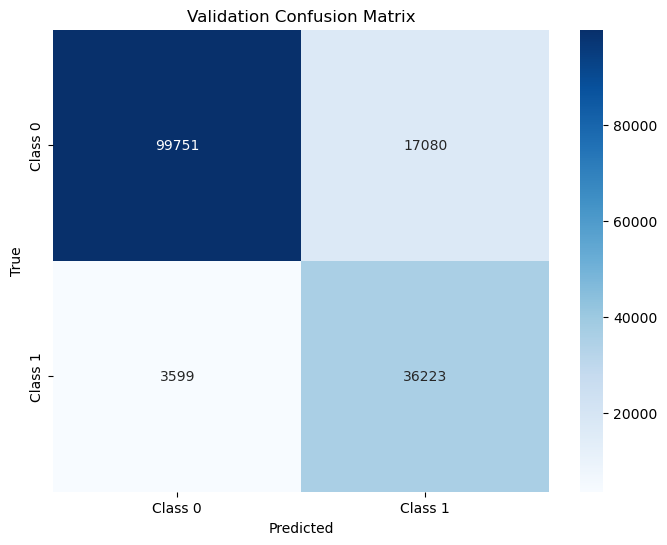

Test Confusion Matrix - XGB:


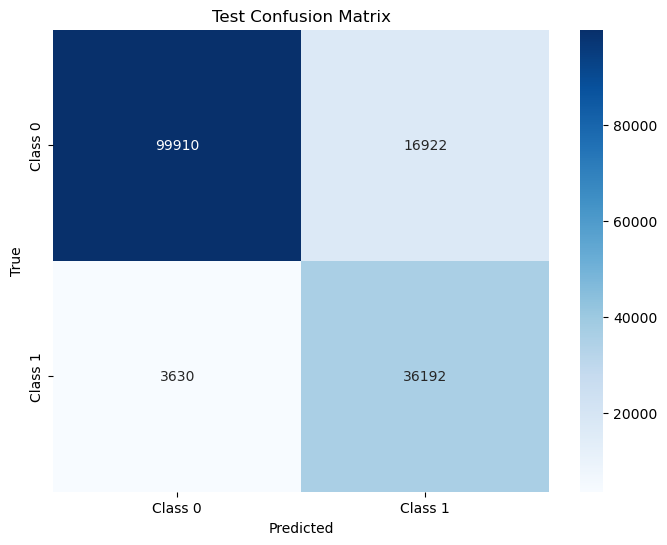

In [28]:
# Plot confusion matrices
print("Validation Confusion Matrix - XGB:")
plot_confusion_matrix(xgb_metrics['Confusion Matrix']['Validation'], 'Validation Confusion Matrix')

print("Test Confusion Matrix - XGB:")
plot_confusion_matrix(xgb_metrics['Confusion Matrix']['Test'], 'Test Confusion Matrix')

The XGBoost model demonstrates strong performance with a validation accuracy of approximately 86.80%, indicating its effectiveness in classifying fraudulent and non-fraudulent cases. The validation confusion matrix shows the model correctly identified 99,751 true negatives and 36,223 true positives, but also made 17,080 false positives and 3,599 false negatives. This highlights the model's overall capability in detecting fraudulent activities, though there are areas for improvement.

Precision for fraudulent cases (Class 1) stands at 0.68, meaning 68% of the predicted fraud cases were accurate. The recall rate for detecting actual fraudulent cases is 0.91, showing that 91% of true fraud cases were identified. The F1-score of 0.78 reflects a balanced trade-off between precision and recall. These metrics are supported by the macro and weighted average scores, which account for class imbalances and provide a comprehensive view of performance.

Evaluating the model on the test set yielded a slightly improved accuracy of 86.88%, with results consistent with the validation metrics. This confirms the model’s reliability across different data subsets. While the XGBoost model performs robustly in detecting healthcare fraud, there is potential for further enhancement, particularly in reducing false positives and negatives. Continued refinement and additional testing could further improve its effectiveness in real-world fraud detection scenarios.

<Figure size 1000x800 with 0 Axes>

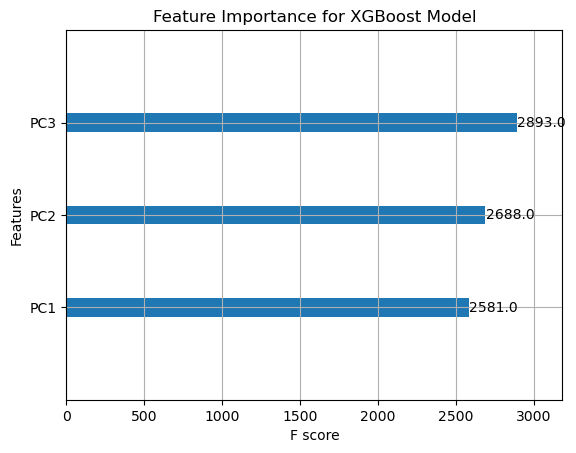

In [30]:
# plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(best_model_xgb, importance_type='weight')
plt.title('Feature Importance for XGBoost Model')
plt.show()

In [32]:
# ensure the models folder exists
os.makedirs('models', exist_ok=True)

# save tuned XGBoost model
xgb_best_model_path = 'models/xgb_best_model.joblib'
joblib.dump(best_model_xgb, xgb_best_model_path)

print(f'Tuned XGBoost model saved at: {xgb_best_model_path}')

Tuned XGBoost model saved at: models/xgb_best_model.joblib


##  Neural Network

Neural Networks were chosen for their ability to model complex patterns and relationships within high-dimensional data. We used a Multi-layer Perceptron (MLP) classifier due to its versatility and effectiveness in handling non-linear data. A parameter grid was defined to optimize the model, including variations in hidden layer sizes, activation functions, and solvers.

### Data Reduction for Faster Training

To speed up the training process, the dataset was reduced in size (data was sampled to 25,000 instances for both training and validation sets):

In [9]:
# reduce datasize for nn model to optimize speed 

# function to reduce dataset size
def reduce_dataset(x, y, sample_size):
    np.random.seed(42)
    indices = np.random.choice(x.shape[0], size=sample_size, replace=False)
    return x[indices], y[indices]

# convert data to np.float32
x_train_np = x_train_scaled_pca.astype(np.float32).to_numpy()
x_val_np = x_val_scaled_pca.astype(np.float32).to_numpy()
x_test_np = x_test_scaled_pca.astype(np.float32).to_numpy()

# sample the data
sample_size = 25000
x_train_sampled, y_train_sampled = reduce_dataset(x_train_np, y_train, sample_size)
x_val_sampled, y_val_sampled = reduce_dataset(x_val_np, y_val, sample_size)
x_test_sampled, y_test_sampled = reduce_dataset(x_test_np, y_test, sample_size)

To optimize the performance of the NN model, a parameter grid was defined, encompassing various configurations of hidden layer sizes, activation functions, solvers, and learning rates. The parameter grid included hidden layer sizes such as (50,), (100,), (100, 50), (150,), and (100, 100), activation functions like 'relu' and 'tanh', and solvers 'adam' and 'sgd'. Additionally, regularization term values (alpha) were varied from 0.0001 to 0.001, learning rate strategies included 'constant' and 'adaptive', and initial learning rates were set to 0.001 and 0.01.

The RandomizedSearchCV was employed for hyperparameter tuning, running 50 iterations with a 3-fold cross-validation approach to identify the optimal hyperparameters for the NN model.

In [37]:
# define the parameter grid
param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (150,), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': uniform(0.0001, 0.001),
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01]
}


# initialize Neural Network model
nn_model = MLPClassifier(max_iter=1000, random_state=42)

# setup RandomSearchCV
random_search_nn = RandomizedSearchCV(
    estimator=nn_model, 
    param_distributions=param_grid_nn, 
    n_iter=50,  
    scoring='accuracy', 
    cv=3, 
    n_jobs=-1, 
    verbose=2,
    random_state=42
)

In [38]:
# fit the model
random_search_nn.fit(x_train_sampled, y_train_sampled)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=MLPClassifier(max_iter=1000, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x17d400ac0>,
                                        'hidden_layer_sizes': [(50,), (100,),
                                                               (100, 50),
                                                               (150,),
                                                               (100, 100)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'learning_rate_init': [0.001, 0.01],
                                        'solver': ['adam', 'sgd']},
                   random_state=42, scoring='accuracy', verbose=2)

In [42]:
# best parameters, estimator, score
best_model_nn = random_search_nn.best_estimator_
best_params_nn = random_search_nn.best_params_
best_score_nn = random_search_nn.best_score_

print(f'Best Parameters for Neural Network: {best_params_nn}')
print(f'Best Cross-Validation Score: {best_score_nn}')

Best Parameters for Neural Network: {'activation': 'relu', 'alpha': 0.0004042422429595377, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'solver': 'adam'}
Best Cross-Validation Score: 0.8778801356037923


The best hyperparameters obtained were: hidden layer sizes of (100, 100), 'relu' activation function, 'adam' solver, 'adaptive' learning rate, an initial learning rate of 0.001, and a regularization term (alpha) of approximately 0.0004.

In [43]:
# evaluate model - val, test, train
nn_metrics = evaluate_model(best_model_nn, x_val_scaled_pca, y_val, x_test_scaled_pca, y_test, x_train_scaled_pca, y_train)

# convert to df
nn_metrics_df = metrics_to_dataframe(nn_metrics)

/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


[CV] END activation=relu, alpha=0.0005458327528535912, hidden_layer_sizes=(100, 50), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   3.0s
[CV] END activation=tanh, alpha=0.0002428668179219408, hidden_layer_sizes=(100, 50), learning_rate=adaptive, learning_rate_init=0.001, solver=sgd; total time=  17.3s
[CV] END activation=relu, alpha=0.00016505159298527952, hidden_layer_sizes=(150,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   4.0s
[CV] END activation=relu, alpha=0.00016505159298527952, hidden_layer_sizes=(150,), learning_rate=constant, learning_rate_init=0.01, solver=sgd; total time=   4.6s
[CV] END activation=tanh, alpha=0.0005401524937396013, hidden_layer_sizes=(150,), learning_rate=constant, learning_rate_init=0.01, solver=adam; total time=   4.0s
[CV] END activation=tanh, alpha=0.0005251558744912447, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, solver=adam; total time=   2.7s
[CV] END activat

In [44]:
print("Neural Network Evaluation Metrics:")
nn_metrics_df

Neural Network Evaluation Metrics:


Type,Metric,CV,Test,Validation
0,Accuracy,0.902297,0.861389,0.860437
1,Classification Report,NaN,"{'0': {'precision': 0.957888048061926, 'recall...","{'0': {'precision': 0.9582866849399684, 'recal..."
2,Confusion Matrix,NaN,"[[99492, 17340], [4374, 35448]]","[[99290, 17541], [4322, 35500]]"
3,F1-Score,NaN,0.765533,0.764567
4,Kappa,0.804593,0.669861,0.668222
5,MCC,0.805707,0.683269,0.682087
6,PR-AUC,0.964526,0.865919,0.866961
7,Precision,NaN,0.671516,0.669294
8,ROC-AUC,0.966975,0.949385,0.949083
9,Recall,NaN,0.890161,0.891467


The performance of the optimized Neural Network model was evaluated using accuracy, precision, recall, F1-score, Kappa, MCC, PR-AUC, and ROC-AUC metrics. The NN model achieved an accuracy of approximately 86.04% on the validation set and 86.14% on the test set. Precision for detecting fraudulent cases was 0.67, while recall was 0.89, indicating a good balance between identifying fraud cases and minimizing false positives. The F1-score of 0.76 reflects this balance, and the ROC-AUC score of 0.95 demonstrates strong overall performance in distinguishing between classes. The confusion matrices for both validation and test sets were plotted to visualize the model’s performance.

Validation Confusion Matrix - Neural Network:


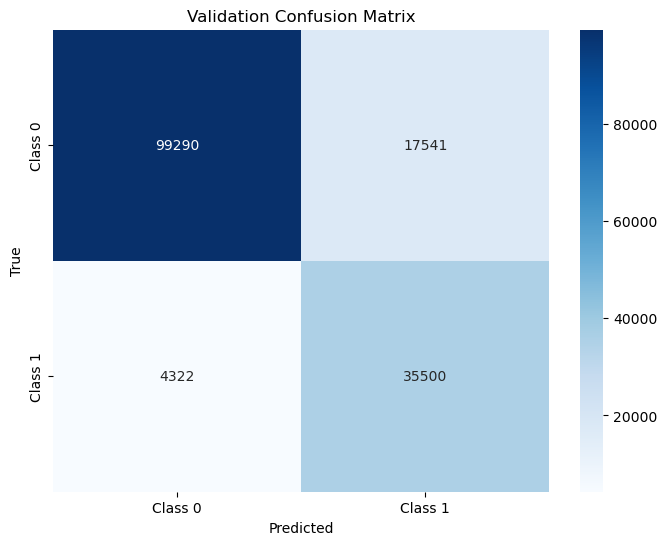

Test Confusion Matrix - Neural Network:


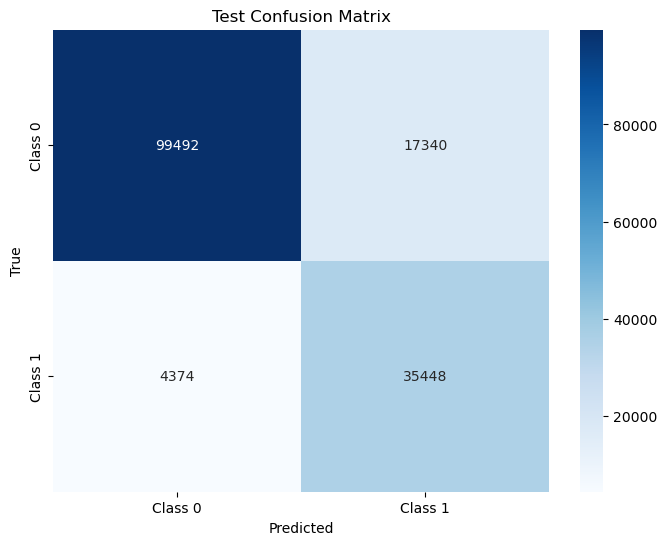

In [45]:
# Plot confusion matrices
print("Validation Confusion Matrix - Neural Network:")
plot_confusion_matrix(nn_metrics['Confusion Matrix']['Validation'], 'Validation Confusion Matrix')

print("Test Confusion Matrix - Neural Network:")
plot_confusion_matrix(nn_metrics['Confusion Matrix']['Test'], 'Test Confusion Matrix')

In [46]:
# ensure the models folder exists
os.makedirs('models', exist_ok=True)

# save tuned XGBoost model
nn_best_model_path = 'models/nn_best_model.joblib'
joblib.dump(best_model_nn, nn_best_model_path)

print(f'Tuned Neural Network model saved at: {nn_best_model_path}')

Tuned Neural Network model saved at: models/nn_best_model.joblib


## Quadratic Discriminant Analysis (QDA)

Quadratic Discriminant Analysis (QDA) was chosen for its ability to model the quadratic decision boundaries between classes, which can be beneficial when the classes are not linearly separable. QDA is particularly effective when the assumption of normally distributed features within each class holds true, providing a good balance between simplicity and performance for certain types of data.

To find the best parameter values, we used GridSearchCV. For QDA, we adjusted key settings including reg_param, store_covariance, and tol. The reg_param controls regularization strength, ranging from 0.0 to 1.0. The store_covariance setting determines if covariance estimates are saved, affecting model flexibility. The tol parameter sets tolerance for handling singular matrices, ranging from 1 x 10^{-4} to 1.0. These adjustments help balance model performance.

In [47]:
# define the parameter grid
param_grid_qda = {
    'reg_param': [0.0, 0.01, 0.1, 0.5, 1.0],
    'store_covariance': [True, False],
    'tol': [1e-4, 1e-3, 1e-2, 1e-1, 1.0]
}

# initialize QDA model
qda_model = QuadraticDiscriminantAnalysis()

# setup GridSearchCV
grid_search_qda = GridSearchCV(estimator=qda_model, 
                               param_grid=param_grid_qda, 
                               scoring='accuracy', 
                               cv=3, n_jobs=2, verbose=2)

In [48]:
# fit the model
grid_search_qda.fit(x_train_scaled_pca, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


GridSearchCV(cv=3, estimator=QuadraticDiscriminantAnalysis(), n_jobs=2,
             param_grid={'reg_param': [0.0, 0.01, 0.1, 0.5, 1.0],
                         'store_covariance': [True, False],
                         'tol': [0.0001, 0.001, 0.01, 0.1, 1.0]},
             scoring='accuracy', verbose=2)

In [49]:
# best parameters, estimator, score
best_model_qda = grid_search_qda.best_estimator_
best_params_qda = grid_search_qda.best_params_
best_score_qda = grid_search_qda.best_score_

print(f'Best Parameters for QDA: {best_params_qda}')
print(f'Best Cross-Validation Score: {best_score_qda}')

Best Parameters for QDA: {'reg_param': 1.0, 'store_covariance': True, 'tol': 0.0001}
Best Cross-Validation Score: 0.6279642193572763


In this case, GridSearchCV explored 50 different parameter combinations across 3 folds, totaling 150 model fits. The grid search identified the optimal parameters as a reg_param of 1.0, store_covariance set to True, and a tol of 0.0001. The best cross-validation score achieved was approximately 62.80%. 

In [51]:
# evaluate model - val, test, train
qda_metrics = evaluate_model(best_model_qda, x_val_scaled_pca, y_val, x_test_scaled_pca, y_test, x_train_scaled_pca, y_train)

# convert to df
qda_metrics_df = metrics_to_dataframe(qda_metrics)

In [52]:
print("QDA Evaluation Metrics:")
qda_metrics_df

QDA Evaluation Metrics:


Type,Metric,CV,Test,Validation
0,Accuracy,0.627964,0.802163,0.801357
1,Classification Report,NaN,"{'0': {'precision': 0.7992609120066936, 'recal...","{'0': {'precision': 0.7986744628508109, 'recal..."
2,Confusion Matrix,NaN,"[[114630, 2202], [28790, 11032]]","[[114601, 2230], [28888, 10934]]"
3,F1-Score,NaN,0.415862,0.412713
4,Kappa,0.255928,0.331027,0.327808
5,MCC,0.361753,0.404225,0.400961
6,PR-AUC,0.870163,0.713707,0.710383
7,Precision,NaN,0.83361,0.830599
8,ROC-AUC,0.89088,0.894094,0.893265
9,Recall,NaN,0.277033,0.274572


The QDA model achieved a cross-validation accuracy of 62.80%, with a test accuracy of 80.22% and a validation accuracy of 80.14%. Precision for the positive class is high at 0.83, while recall is lower at 0.28, indicating a challenge in identifying all positive cases. The F1-score is around 0.42, reflecting a trade-off between precision and recall. The ROC-AUC of 0.89 suggests good discriminative power, and the PR-AUC of 0.71 highlights performance in precision-recall scenarios. The confusion matrices show that the model performs well in classifying the majority class but struggles with the minority class.

Validation Confusion Matrix - QDA:


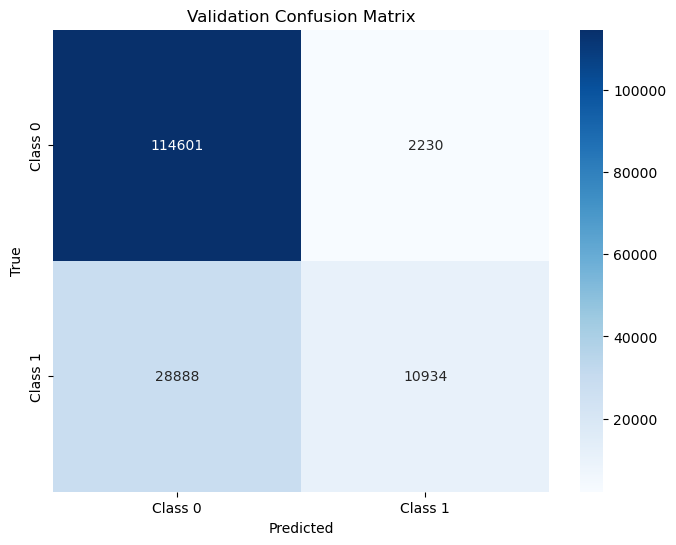

Test Confusion Matrix - QDA:


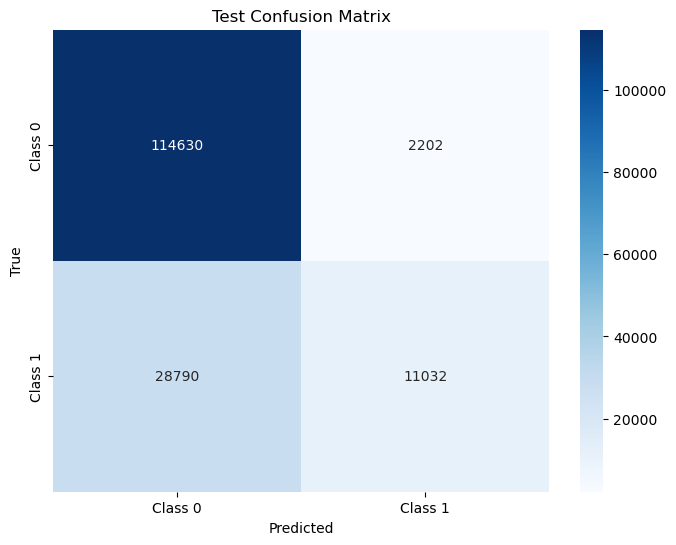

In [53]:
# plot confusion matrices
print("Validation Confusion Matrix - QDA:")
plot_confusion_matrix(qda_metrics['Confusion Matrix']['Validation'], 'Validation Confusion Matrix')

print("Test Confusion Matrix - QDA:")
plot_confusion_matrix(qda_metrics['Confusion Matrix']['Test'], 'Test Confusion Matrix')

In [54]:
# ensure the models folder exists
os.makedirs('models', exist_ok=True)

# save tuned QDA model
qda_best_model_path = 'models/qda_best_model.joblib'
joblib.dump(best_model_qda, qda_best_model_path)

print(f'Tuned QDA model saved at: {qda_best_model_path}')

Tuned QDA model saved at: models/qda_best_model.joblib


## Adaboost

AdaBoost (Adaptive Boosting) was selected for its ability to enhance the performance of weak classifiers by focusing on the instances that are hardest to classify. This iterative technique adjusts the weights of incorrectly classified instances, allowing the model to correct its mistakes and improve overall accuracy.

We'll look into Adaboost before and after applyimg parameters through RandomSearchCV. 

In this implementation, a DecisionTreeClassifier with a maximum depth of 1 is used as the base model for AdaBoost. This shallow tree acts as the weak learner in the ensemble. The AdaBoostClassifier is initialized with this base model and configured to use the SAMME algorithm, which is suitable for multi-class classification problems.

In [55]:
# initialize the base model
base_model = DecisionTreeClassifier(max_depth=1)

# initialize the AdaBoost model with the base model
adaboost_model = AdaBoostClassifier(estimator=base_model, algorithm='SAMME', random_state=42)

# train the model on the PCA-transformed and scaled training data
adaboost_model.fit(x_train_scaled_pca, y_train)

# predict on the PCA-transformed and scaled training data
y_train_pred = adaboost_model.predict(x_train_scaled_pca)

# predict on the PCA-transformed and scaled validation data
y_val_pred = adaboost_model.predict(x_val_scaled_pca)

# predict on the PCA-transformed and scaled test data
y_test_pred = adaboost_model.predict(x_test_scaled_pca)

# evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Training Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {val_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

Training Accuracy: 0.8450554005696878
Validation Accuracy: 0.8055192048668075
Test Accuracy: 0.8061268783433554

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.96      0.77      0.86    116831
           1       0.57      0.91      0.70     39822

    accuracy                           0.81    156653
   macro avg       0.77      0.84      0.78    156653
weighted avg       0.86      0.81      0.82    156653


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.96      0.77      0.86    116832
           1       0.57      0.91      0.70     39822

    accuracy                           0.81    156654
   macro avg       0.77      0.84      0.78    156654
weighted avg       0.86      0.81      0.82    156654



The AdaBoost model performs well, achieving high precision of 0.96 for the negative class and high recall of 0.91 for the positive class. However, precision for the positive class is lower at 0.57, indicating fewer reliable positive predictions. The overall accuracy is around 81%, with a good balance in F1-scores for both classes, showing effective performance in identifying both classes despite some imbalance.

To optimize AdaBoost's performance, we applied RandomSearchCV to identify the best combination of combination of hyperparameters. The parameter grid includes n_estimators, which defines the number of boosting stages, and learning_rate, which controls the contribution of each weak learner to the final model. Additionally, the max_depth of the base DecisionTreeClassifier is adjusted to explore different complexities of the base model.

In [61]:
# define the parameter distribution
param_dist = {
    'n_estimators': randint(50, 200),  # Number of boosting stages to be run
    'learning_rate': uniform(0.01, 0.3),  # Learning rate shrinks the contribution of each tree
    'estimator__max_depth': randint(1, 4)  # Hyperparameter for base estimator
}

# initialize the AdaBoost classifier with a base estimator
base_estimator = DecisionTreeClassifier()
adaboost_model = AdaBoostClassifier(estimator=base_model, algorithm='SAMME', random_state=42)

# setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=adaboost_model,
    param_distributions=param_grid,
    scoring='accuracy',  
    cv=5,  
    n_jobs=-1,  
    verbose=1,  
    n_iter=27
)

In [62]:
random_search.fit(x_train_sampled, y_train_sampled )

Fitting 5 folds for each of 27 candidates, totalling 135 fits


RandomizedSearchCV(cv=5,
                   estimator=AdaBoostClassifier(algorithm='SAMME',
                                                estimator=DecisionTreeClassifier(max_depth=1),
                                                random_state=42),
                   n_iter=27, n_jobs=-1,
                   param_distributions={'estimator__max_depth': [1, 2, 3],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'n_estimators': [50, 100, 150]},
                   scoring='accuracy', verbose=1)

In [63]:
best_params_ada = random_search.best_params_
best_model_ada = random_search.best_estimator_
best_score_ada = random_search.best_score_

print(f"Best Parameters: {best_params_ada}")
print(f"Best Cross-Validation Score: {best_score_ada:.4f}")

Best Parameters: {'n_estimators': 150, 'learning_rate': 0.2, 'estimator__max_depth': 3}
Best Cross-Validation Score: 0.8506


The optimal parameters for the AdaBoost model are 150 estimators, a learning rate of 0.2, and a maximum depth of 3 for the base decision tree. With these settings, the model achieved a top cross-validation score of 0.8506, reflecting strong overall performance and effective parameter tuning.

In [64]:
# evaluate model - val, test, train
ada_metrics = evaluate_model(best_model_ada, x_val_scaled_pca, y_val, x_test_scaled_pca, y_test, x_train_scaled_pca, y_train)

# convert to df
ada_metrics_df = metrics_to_dataframe(ada_metrics)

/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


In [65]:
print("AdaBoost Evaluation Metrics:")
ada_metrics_df

AdaBoost Evaluation Metrics:


Type,Metric,CV,Test,Validation
0,Accuracy,0.850092,0.827505,0.8264
1,Classification Report,NaN,"{'0': {'precision': 0.9516878570853786, 'recal...","{'0': {'precision': 0.9528076946392128, 'recal..."
2,Confusion Matrix,NaN,"[[94613, 22219], [4803, 35019]]","[[94307, 22524], [4671, 35151]]"
3,F1-Score,NaN,0.721595,0.721068
4,Kappa,0.700184,0.602383,0.601097
5,MCC,0.701728,0.623194,0.622832
6,PR-AUC,0.923106,0.805939,0.808221
7,Precision,NaN,0.611814,0.609467
8,ROC-AUC,0.932538,0.927767,0.927823
9,Recall,NaN,0.879388,0.882703


The AdaBoost model demonstrates robust performance across various metrics. It achieves an accuracy of 85.01% in cross-validation and 82.75% on the test set, indicating solid generalization. The model excels in precision and recall, with high values in both the precision (0.61) and recall (0.88) metrics, reflecting its effectiveness in identifying true positives. The F1-score remains consistent around 0.72, showing a balanced performance between precision and recall. The ROC-AUC score of 0.93 highlights excellent discrimination ability, while the PR-AUC of 0.81 emphasizes strong performance in precision-recall trade-offs. The confusion matrices further illustrate that the model maintains a good balance between true and false classifications. Overall, the AdaBoost model is well-tuned and performs effectively across different evaluation criteria.

Validation Confusion Matrix - QDA:


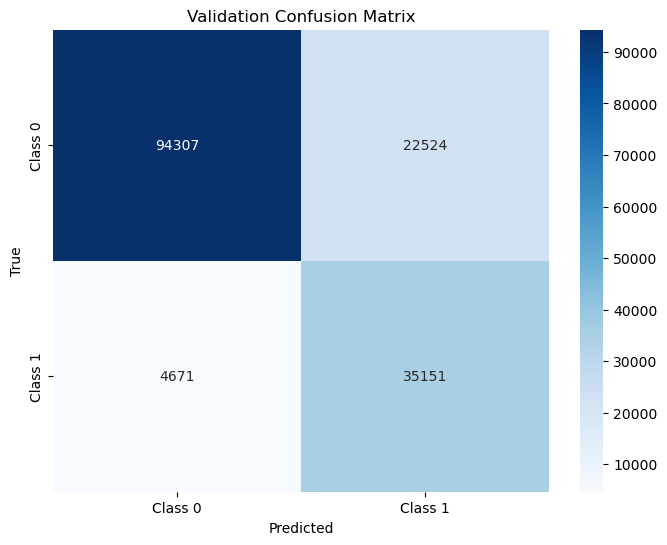

Test Confusion Matrix - QDA:


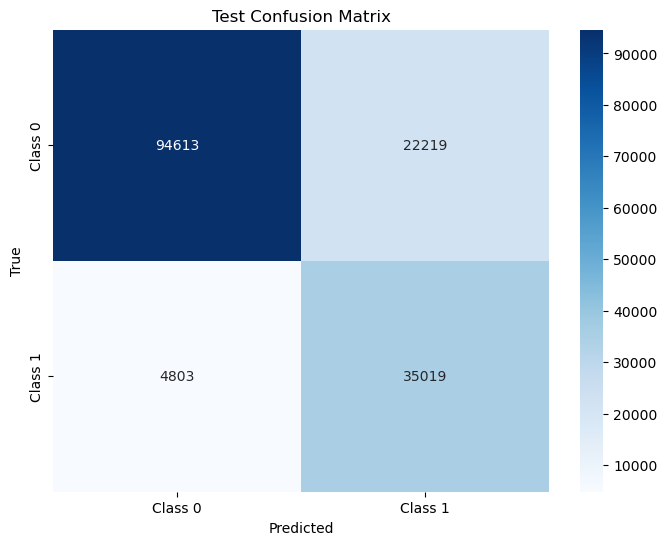

In [66]:
# plot confusion matrices
print("Validation Confusion Matrix - QDA:")
plot_confusion_matrix(ada_metrics['Confusion Matrix']['Validation'], 'Validation Confusion Matrix')

print("Test Confusion Matrix - QDA:")
plot_confusion_matrix(ada_metrics['Confusion Matrix']['Test'], 'Test Confusion Matrix')

In [68]:
# ensure the models folder exists
os.makedirs('models', exist_ok=True)

# save tuned QDA model
ada_best_model_path = 'models/ada_best_model.joblib'
joblib.dump(best_model_ada, ada_best_model_path)

print(f'Tuned AdaBoost model saved at: {ada_best_model_path}')

Tuned AdaBoost model saved at: models/ada_best_model.joblib


## SVM model with kernel trick

In [10]:
# Create the SVM model with a kernel trick, for example, the 'rbf' kernel - use sample of df 
svm_model = SVC(kernel='rbf', C=1, gamma='scale')

# Train the model on the sampled data
svm_model.fit(x_train_sampled, y_train_sampled)

# Make predictions on the validation set
y_val_pred = svm_model.predict(x_val_sampled)

# Evaluate the model
print("Validation Accuracy:", accuracy_score(y_val_sampled, y_val_sampled))
print("Classification Report:\n", classification_report(y_val_sampled, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val_sampled, y_val_pred))

# Make predictions on the test set
y_test_pred = svm_model.predict(x_test_sampled)

# Evaluate the model on the test set
print("Test Accuracy:", accuracy_score(y_test_sampled, y_test_pred))
print("Classification Report:\n", classification_report(y_test_sampled, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_sampled, y_test_pred))

Validation Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90     18685
           1       0.69      0.70      0.69      6315

    accuracy                           0.85     25000
   macro avg       0.79      0.80      0.80     25000
weighted avg       0.85      0.85      0.85     25000

Confusion Matrix:
 [[16721  1964]
 [ 1906  4409]]
Test Accuracy: 0.84604
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90     18377
           1       0.71      0.70      0.71      6623

    accuracy                           0.85     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.85      0.85      0.85     25000

Confusion Matrix:
 [[16495  1882]
 [ 1967  4656]]


In [11]:
# define the parameter distribution
param_dist = {
    'C': uniform(0.1, 10),  # Regularization parameter
    'gamma': uniform(0.001, 0.1)  # Kernel coefficient
}

# initialize the SVM model
svm_model = SVC(kernel='rbf', random_state=42)

# setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=svm_model,
    param_distributions=param_dist,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1,
    n_iter=27,
    random_state=42
)

In [12]:
# fit RandomizedSearchCV on subsection of df for faster model processing 
random_search.fit(x_train_sampled, y_train_sampled)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


RandomizedSearchCV(cv=5, estimator=SVC(random_state=42), n_iter=27, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x17478a340>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1271bf430>},
                   random_state=42, scoring='accuracy', verbose=1)

In [13]:
# get best parameter, score, and model
best_params_svm = random_search.best_params_
best_model_svm = random_search.best_estimator_
best_score_svm = random_search.best_score_

print(f"Best Parameters: {best_params_svm}")
print(f"Best Cross-Validation Score: {best_score_svm:.4f}")

Best Parameters: {'C': 9.494989415641891, 'gamma': 0.09048273504276488}
Best Cross-Validation Score: 0.8588


In [14]:
# evaluate model - val, test, train
svm_metrics = evaluate_model_2(best_model_svm, x_val_sampled, y_val_sampled, x_test_sampled, y_test_sampled, x_train_sampled, y_train_sampled)

# convert to df
svm_metrics_df = metrics_to_dataframe(svm_metrics)

In [15]:
print("Support Vector Machine Evaluation Metrics:")
svm_metrics_df

Support Vector Machine Evaluation Metrics:


Type,Metric,CV,Test,Validation
0,Accuracy,0.85832,0.85144,0.84472
1,Classification Report,NaN,"{'0': {'precision': 0.9482178883658372, 'recal...","{'0': {'precision': 0.9489294595742099, 'recal..."
2,Confusion Matrix,NaN,"[[15510, 2867], [847, 5776]]","[[15645, 3040], [842, 5473]]"
3,F1-Score,NaN,0.756714,0.738198
4,Kappa,0.716572,0.652462,0.631242
5,MCC,0.717277,0.66444,0.645468
6,Precision,NaN,0.668286,0.642899
7,Recall,NaN,0.872112,0.866667


Validation Confusion Matrix - SVM:


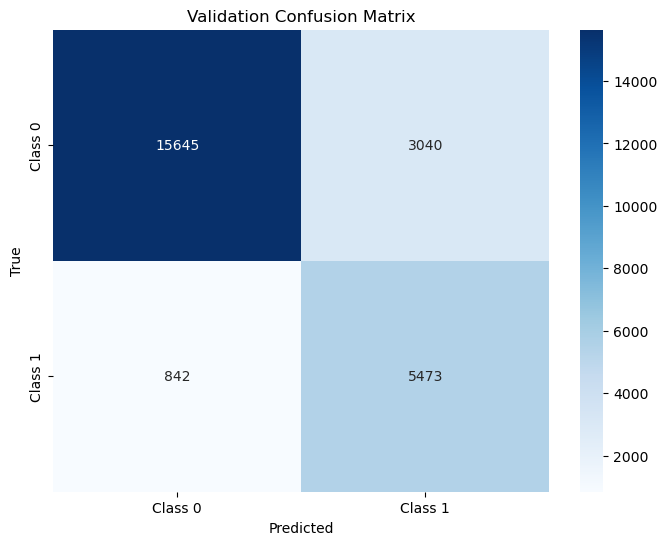

Test Confusion Matrix - SVM:


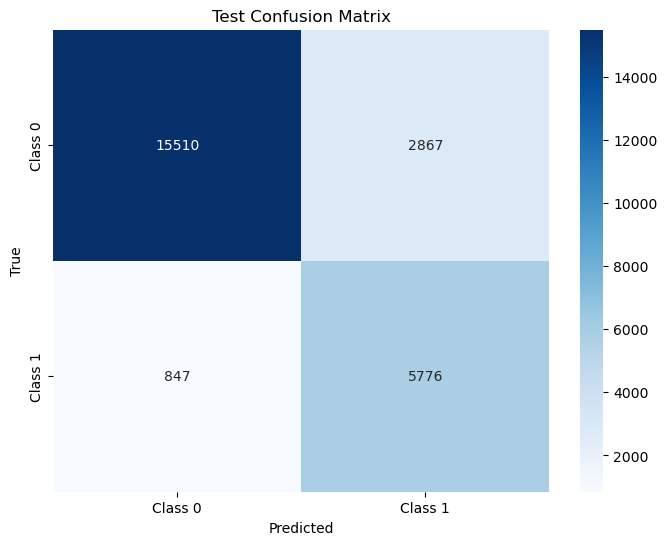

In [16]:
# plot confusion matrices
print("Validation Confusion Matrix - SVM:")
plot_confusion_matrix(svm_metrics['Confusion Matrix']['Validation'], 'Validation Confusion Matrix')

print("Test Confusion Matrix - SVM:")
plot_confusion_matrix(svm_metrics['Confusion Matrix']['Test'], 'Test Confusion Matrix')

In [18]:
# save tuned svm model 
svm_best_model_path = 'models/svm_best_model.pkl'

joblib.dump(best_model_svm, svm_best_model_path)

print(f'Tuned Support Vector Machine model saved at: {svm_best_model_path}')

Tuned Support Vector Machine model saved at: models/svm_best_model.pkl


## Stochastic Gradient Descent Classifier (SGD)

In [73]:
# initialize and train SGDClassifier with a linear kernel
# loss function is 'hinge' which is used for linear SVM
sgd_model = SGDClassifier(loss='hinge',  # Linear SVM
                          alpha=0.0001,  # Regularization parameter
                          max_iter=1000,  # Number of iterations
                          tol=1e-3,       # Tolerance for stopping criteria
                          random_state=42)

sgd_model.fit(x_train_scaled_pca, y_train)

# Make predictions
y_pred = sgd_model.predict(x_test_scaled_pca)

# Print performance metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8327588187981156
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89    116832
           1       0.75      0.52      0.61     39822

    accuracy                           0.83    156654
   macro avg       0.80      0.73      0.75    156654
weighted avg       0.82      0.83      0.82    156654



In [76]:
# Define the parameter grid
param_grid = {
    'alpha': [0.0001, 0.001, 0.01],       # Regularization parameter
    'max_iter': [5000, 10000, 20000],        # Number of iterations
    'tol': [1e-3, 1e-4, 1e-5],              # Tolerance for stopping criteria
    'penalty': ['l2', 'l1', 'elasticnet']  # Type of regularization
}

# Initialize the SGDClassifier
sgd = SGDClassifier(loss='hinge', random_state=42)

# Configure Grid Search
grid_search = GridSearchCV(estimator=sgd,
                           param_grid=param_grid,
                           scoring='accuracy',   # Use accuracy to evaluate performance
                           cv=5,                 # Number of cross-validation folds
                           verbose=2,            # Print detailed logs
                           n_jobs=-1)            # Use all available CPUs

In [77]:
# Fit Grid Search
grid_search.fit(x_train_scaled_pca, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fi

[CV] END alpha=0.0001, max_iter=5000, penalty=l2, tol=0.0001; total time=  12.8s
[CV] END .alpha=0.0001, max_iter=5000, penalty=l1, tol=0.001; total time=   4.6s
[CV] END .alpha=0.0001, max_iter=5000, penalty=l1, tol=0.001; total time=   4.6s
[CV] END .alpha=0.0001, max_iter=5000, penalty=l1, tol=1e-05; total time=  14.2s
[CV] END alpha=0.0001, max_iter=5000, penalty=elasticnet, tol=0.0001; total time=  10.1s
[CV] END alpha=0.0001, max_iter=10000, penalty=l2, tol=0.001; total time=   4.3s
[CV] END alpha=0.0001, max_iter=10000, penalty=l2, tol=0.001; total time=   4.3s
[CV] END alpha=0.0001, max_iter=10000, penalty=l2, tol=1e-05; total time=   8.9s
[CV] END alpha=0.0001, max_iter=10000, penalty=l1, tol=0.001; total time=   5.6s
[CV] END alpha=0.0001, max_iter=10000, penalty=l1, tol=0.0001; total time=  10.0s
[CV] END alpha=0.0001, max_iter=10000, penalty=elasticnet, tol=0.001; total time=   4.5s
[CV] END alpha=0.0001, max_iter=10000, penalty=elasticnet, tol=0.0001; total time=  12.1s
[C

/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/samantharivas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


GridSearchCV(cv=5, estimator=SGDClassifier(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'max_iter': [5000, 10000, 20000],
                         'penalty': ['l2', 'l1', 'elasticnet'],
                         'tol': [0.001, 0.0001, 1e-05]},
             scoring='accuracy', verbose=2)

In [78]:
best_params_sgd = grid_search.best_params_
best_model_sgd = grid_search.best_estimator_
best_score_sgd = grid_search.best_score_

print(f"Best Parameters: {best_params_sgd}")
print(f"Best Cross-Validation Score: {best_score_sgd:.4f}")

Best Parameters: {'alpha': 0.01, 'max_iter': 20000, 'penalty': 'l1', 'tol': 1e-05}
Best Cross-Validation Score: 0.7422


In [81]:
# evaluate model - val, test, train
sgd_metrics = evaluate_model_2(best_model_sgd, x_val_scaled_pca, y_val, x_test_scaled_pca, y_test, x_train_scaled_pca, y_train)

# convert to df
sgd_metrics_df = metrics_to_dataframe(sgd_metrics)

In [83]:
print("Stochastic Gradient Descent Classifier Evaluation Metrics:")
sgd_metrics_df

Stochastic Gradient Descent Classifier Evaluation Metrics:


Type,Metric,CV,Test,Validation
0,Accuracy,0.727473,0.830135,0.8291
1,Classification Report,NaN,"{'0': {'precision': 0.8493835001084297, 'recal...","{'0': {'precision': 0.8492960477834232, 'recal..."
2,Confusion Matrix,NaN,"[[109669, 7163], [19447, 20375]]","[[109487, 7344], [19428, 20394]]"
3,F1-Score,NaN,0.604958,0.60373
4,Kappa,0.454947,0.501307,0.499193
5,MCC,0.501405,0.515144,0.512457
6,Precision,NaN,0.739887,0.735237
7,Recall,NaN,0.511652,0.512129


Validation Confusion Matrix - SGD:


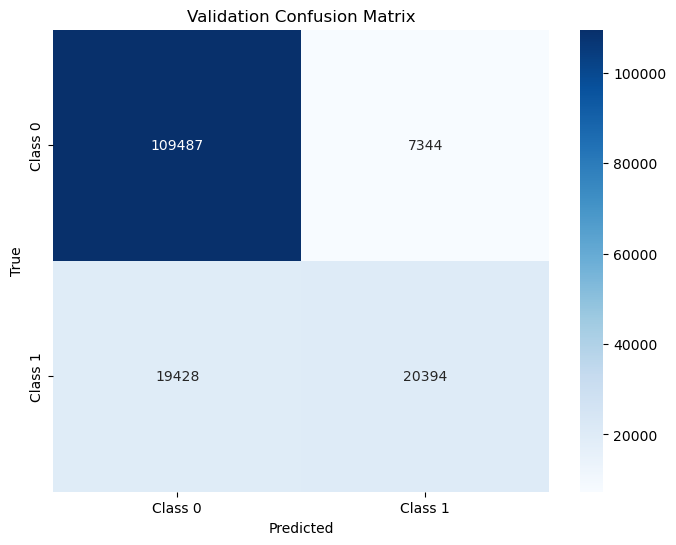

Test Confusion Matrix - SGD:


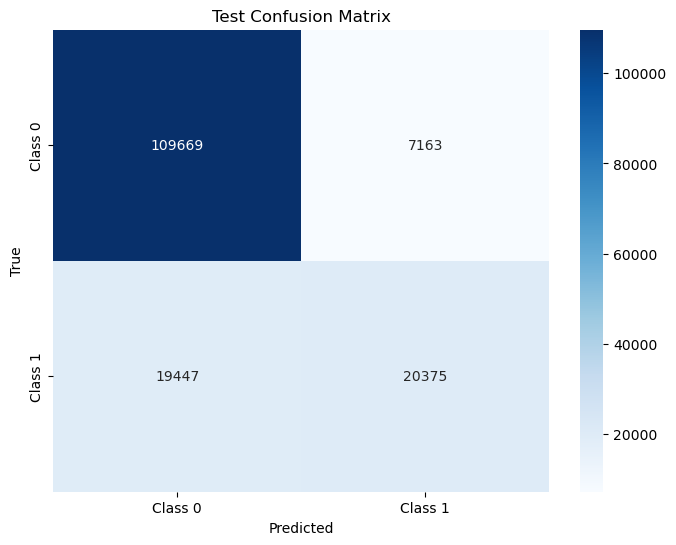

In [82]:
# plot confusion matrices
print("Validation Confusion Matrix - SGD:")
plot_confusion_matrix(sgd_metrics['Confusion Matrix']['Validation'], 'Validation Confusion Matrix')

print("Test Confusion Matrix - SGD:")
plot_confusion_matrix(sgd_metrics['Confusion Matrix']['Test'], 'Test Confusion Matrix')

In [85]:
# save tuned sgd model 
sgd_best_model_path = 'models/sgd_best_model.pkl'

joblib.dump(best_model_sgd, sgd_best_model_path)

print(f'Tuned adaboost model saved at: {sgd_best_model_path}')

Tuned adaboost model saved at: models/sgd_best_model.pkl


### Logistic modeling with Lasso / Ridge

In looking to refine the Logistic regression model for higher accuracy, the lasso and ridge variation of the model was utilized. First, the data x_train_scaled_pca was fitted to the default Ridge and Lasso models. Five fold cross validation was used to get the average accuracy of each model. The average accuracy for each model is as follows:

| Model | Parameters | Dataset | Accuracy |
| --- | --- | --- | --- |
| Ridge | Default | 5-Fold Validation | 0.73 (average)|
|  | Default | Single Validation |  0.82 |
|  | Default | Test |  0.83 |
|  | Tuned, C = 1 | Validation |   0.82 |
|  | Test, C = 1 | Test |  0.83 |
| Lasso | Default | 5-Fold Validation |  0.73 (average)|
|  | Default | Single Validation |  0.82 |
|  | Default | Test |  0.83 |
|  | Tuned, C = 1 | Single Validation |  0.82 |
|  | Tuned, C = 1 | Test |  0.83 |

In [19]:
# Number of folds
n_splits = 5

# K-Fold cross-validator
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Ridge Classification with K-Fold CV
ridge_model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, random_state= 42)
ridge_accuracy_scores = cross_val_score(ridge_model, x_train_scaled_pca, y_train, cv=kf, scoring='accuracy')

print(f'Ridge Classification Accuracy CV Scores: {ridge_accuracy_scores}')
print(f'Ridge Classification Mean Accuracy CV Score: {np.mean(ridge_accuracy_scores)}')

# Lasso Classification with K-Fold CV
lasso_model = LogisticRegression(penalty='l1', solver='saga', max_iter=1000, random_state= 42)  # 'saga' solver supports L1 regularization
lasso_accuracy_scores = cross_val_score(lasso_model, x_train_scaled_pca, y_train, cv=kf, scoring='accuracy')

print(f'Lasso Classification Accuracy CV Scores: {lasso_accuracy_scores}')
print(f'Lasso Classification Mean Accuracy CV Score: {np.mean(lasso_accuracy_scores)}')

# Training the models on the entire training set and evaluating on the validation set
ridge_model.fit(x_train_scaled_pca, y_train)
lasso_model.fit(x_train_scaled_pca, y_train)

# Evaluate Ridge model on the validation set
y_val_pred_ridge = ridge_model.predict(x_val_scaled_pca)
val_accuracy_ridge = accuracy_score(y_val, y_val_pred_ridge)
val_confusion_matrix_ridge = confusion_matrix(y_val, y_val_pred_ridge)
val_classification_report_ridge = classification_report(y_val, y_val_pred_ridge)

print('\nRidge Classification Validation Confusion Matrix:')
print(val_confusion_matrix_ridge)
print('Ridge Classification Validation Classification Report:')
print(val_classification_report_ridge)
print(f'Ridge Classification Validation Accuracy: {val_accuracy_ridge}')

# Evaluate Ridge model on the test set
y_test_pred_ridge = ridge_model.predict(x_test_scaled_pca)
test_accuracy_ridge = accuracy_score(y_test, y_test_pred_ridge)
test_confusion_matrix_ridge = confusion_matrix(y_test, y_test_pred_ridge)
test_classification_report_ridge = classification_report(y_test, y_test_pred_ridge)

print('\nRidge Classification Test Confusion Matrix:')
print(test_confusion_matrix_ridge)
print('\nRidge Classification Test Classification Report:')
print(test_classification_report_ridge)
print(f'Ridge Classification Test Accuracy: {test_accuracy_ridge}')

# Evaluate Lasso model on the validation set
y_val_pred_lasso = lasso_model.predict(x_val_scaled_pca)
val_accuracy_lasso = accuracy_score(y_val, y_val_pred_lasso)
val_confusion_matrix_lasso = confusion_matrix(y_val, y_val_pred_lasso)
val_classification_report_lasso = classification_report(y_val, y_val_pred_lasso)

print('\nLasso Classification Validation Confusion Matrix:')
print(val_confusion_matrix_lasso)
print('Lasso Classification Validation Classification Report:')
print(val_classification_report_lasso)
print(f'Lasso Classification Validation Accuracy: {val_accuracy_lasso}')

# Evaluate Lasso model on the test set
y_test_pred_lasso = lasso_model.predict(x_test_scaled_pca)
val_accuracy_lasso = accuracy_score(y_test, y_test_pred_lasso)
val_confusion_matrix_lasso = confusion_matrix(y_test, y_test_pred_lasso)
val_classification_report_lasso = classification_report(y_test, y_test_pred_lasso)

print('\nLasso Classification Test Confusion Matrix:')
print(val_confusion_matrix_lasso)
print('\nLasso Classification Test Classification Report:')
print(val_classification_report_lasso)
print(f'Lasso Classification Test Accuracy: {val_accuracy_lasso}')

Ridge Classification Accuracy CV Scores: [0.73285187 0.73231997 0.73140166 0.73313494 0.73158966]
Ridge Classification Mean Accuracy CV Score: 0.732259619988778
Lasso Classification Accuracy CV Scores: [0.73211821 0.73144416 0.73053044 0.7325205  0.73081473]
Lasso Classification Mean Accuracy CV Score: 0.7314856077819808

Ridge Classification Validation Confusion Matrix:
[[107864   8967]
 [ 18655  21167]]
Ridge Classification Validation Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.89    116831
           1       0.70      0.53      0.61     39822

    accuracy                           0.82    156653
   macro avg       0.78      0.73      0.75    156653
weighted avg       0.81      0.82      0.81    156653

Ridge Classification Validation Accuracy: 0.8236739800706019

Ridge Classification Test Confusion Matrix:
[[108066   8766]
 [ 18623  21199]]

Ridge Classification Test Classification Report:
              prec

##### Hyper parameter tuning for the Ridge and Lasso Models

In [20]:
# Define the parameter grid for Ridge and Lasso
ridge_param_grid = {
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1, 10, 100],  # inverse of regularization strength
    'solver': ['lbfgs'],
    'max_iter': [1000],
    'random_state': [42]  # set seed
}

lasso_param_grid = {
    'penalty': ['l1'],
    'C': [0.01, 0.1, 1, 10, 100],  # inverse of regularization strength
    'solver': ['saga'],
    'max_iter': [1000],
    'random_state': [42]  # Set the seed
}

# Create GridSearchCV objects
ridge_grid_search = GridSearchCV(
    LogisticRegression(random_state=42),  # set seed for reproducibility
    ridge_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  
    n_jobs=-1  # use all available cores
)

lasso_grid_search = GridSearchCV(
    LogisticRegression(random_state=42),  # set seed for reproducibility
    lasso_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  
    n_jobs=-1  # use all available cores
)

# Fit GridSearchCV objects
ridge_grid_search.fit(x_train_scaled_pca, y_train)
lasso_grid_search.fit(x_train_scaled_pca, y_train)

# Get the best parameters and best scores
print(f'\nBest Ridge parameters: {ridge_grid_search.best_params_}')
print(f'Best Ridge CV accuracy: {ridge_grid_search.best_score_}')

print(f'\nBest Lasso parameters: {lasso_grid_search.best_params_}')
print(f'Best Lasso CV accuracy: {lasso_grid_search.best_score_}')

# Evaluate the best model on the validation set
best_ridge_model = ridge_grid_search.best_estimator_
best_lasso_model = lasso_grid_search.best_estimator_

# Validation set evaluation for Ridge
y_val_pred_ridge = best_ridge_model.predict(x_val_scaled_pca)
val_accuracy_ridge = accuracy_score(y_val, y_val_pred_ridge)
val_confusion_matrix_ridge = confusion_matrix(y_val, y_val_pred_ridge)
val_classification_report_ridge = classification_report(y_val, y_val_pred_ridge)


print('\nBest Ridge Classification Validation Confusion Matrix:')
print(val_confusion_matrix_ridge)
print('Best Ridge Classification Validation Classification Report:')
print(val_classification_report_ridge)
print(f'Best Ridge Classification Validation Accuracy: {val_accuracy_ridge}')

# Test set evaluation for Ridge
y_test_pred_ridge = best_ridge_model.predict(x_test_scaled_pca)
test_accuracy_ridge = accuracy_score(y_test, y_test_pred_ridge)
test_confusion_matrix_ridge = confusion_matrix(y_test, y_test_pred_ridge)
test_classification_report_ridge = classification_report(y_test, y_test_pred_ridge)



print('\nBest Ridge Classification Test Confusion Matrix:')
print(test_confusion_matrix_ridge)
print('Best Ridge Classification Test Classification Report:')
print(test_classification_report_ridge)
print(f'Best Ridge Classification Test Accuracy: {test_accuracy_ridge}')

# Validation set evaluation for Lasso
y_val_pred_lasso = best_lasso_model.predict(x_val_scaled_pca)
val_accuracy_lasso = accuracy_score(y_val, y_val_pred_lasso)
val_confusion_matrix_lasso = confusion_matrix(y_val, y_val_pred_lasso)
val_classification_report_lasso = classification_report(y_val, y_val_pred_lasso)



print('\nBest Lasso Classification Validation Confusion Matrix:')
print(val_confusion_matrix_lasso)
print('Best Lasso Classification Validation Classification Report:')
print(val_classification_report_lasso)
print(f'Best Lasso Classification Validation Accuracy: {val_accuracy_lasso}')

# Test set evaluation for Lasso
y_test_pred_lasso = best_lasso_model.predict(x_test_scaled_pca)
test_accuracy_lasso = accuracy_score(y_test, y_test_pred_lasso)
test_confusion_matrix_lasso = confusion_matrix(y_test, y_test_pred_lasso)
test_classification_report_lasso = classification_report(y_test, y_test_pred_lasso)


print('\nBest Lasso Classification Test Confusion Matrix:')
print(test_confusion_matrix_lasso)
print('Best Lasso Classification Test Classification Report:')
print(test_classification_report_lasso)
print(f'Best Lasso Classification Test Accuracy: {test_accuracy_lasso}')


Best Ridge parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}
Best Ridge CV accuracy: 0.7322238618046676

Best Lasso parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga'}
Best Lasso CV accuracy: 0.7314828645004297

Best Ridge Classification Validation Confusion Matrix:
[[107863   8968]
 [ 18655  21167]]
Best Ridge Classification Validation Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.89    116831
           1       0.70      0.53      0.61     39822

    accuracy                           0.82    156653
   macro avg       0.78      0.73      0.75    156653
weighted avg       0.81      0.82      0.81    156653

Best Ridge Classification Validation Accuracy: 0.8236675965350169

Best Ridge Classification Test Confusion Matrix:
[[108066   8766]
 [ 18623  21199]]
Best Ridge Classification Test Classification Report:
              pr

In [21]:
best_params_ridge = ridge_grid_search.best_params_
best_score_ridge = ridge_grid_search.best_score_

print(f"Best Parameters: {best_params_ridge}")
print(f"Best Cross-Validation Score: {best_score_ridge:.4f}")

Best Parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}
Best Cross-Validation Score: 0.7322


In [22]:
best_params_lasso = lasso_grid_search.best_params_
best_score_lasso = lasso_grid_search.best_score_

print(f"Best Parameters: {best_params_lasso}")
print(f"Best Cross-Validation Score: {best_score_lasso:.4f}")

Best Parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga'}
Best Cross-Validation Score: 0.7315


In [24]:
# evaluate model - val, test, train
lasso_metrics = evaluate_model(best_lasso_model, x_val_scaled_pca, y_val, x_test_scaled_pca, y_test, x_train_scaled_pca, y_train)

# convert to df
lasso_metrics_df = metrics_to_dataframe(lasso_metrics)

In [26]:
print("Lasso Evaluation Metrics:")
lasso_metrics_df

Lasso Evaluation Metrics:


Type,Metric,CV,Test,Validation
0,Accuracy,0.731323,0.825245,0.823763
1,Classification Report,NaN,"{'0': {'precision': 0.8526666035891128, 'recal...","{'0': {'precision': 0.8522284947297778, 'recal..."
2,Confusion Matrix,NaN,"[[108142, 8690], [18686, 21136]]","[[107939, 8892], [18716, 21106]]"
3,F1-Score,NaN,0.606938,0.604583
4,Kappa,0.462647,0.497543,0.494069
5,MCC,0.502025,0.506134,0.502276
6,PR-AUC,0.854302,0.67767,0.672808
7,Precision,NaN,0.708643,0.70358
8,ROC-AUC,0.874581,0.866117,0.864548
9,Recall,NaN,0.530762,0.530009


In [27]:
# evaluate model - val, test, train
ridge_metrics = evaluate_model(best_ridge_model, x_val_scaled_pca, y_val, x_test_scaled_pca, y_test, x_train_scaled_pca, y_train)

# convert to df
ridge_metrics_df = metrics_to_dataframe(ridge_metrics)

In [28]:
print("Ridge Evaluation Metrics:")
ridge_metrics_df

Ridge Evaluation Metrics:


Type,Metric,CV,Test,Validation
0,Accuracy,0.732156,0.825162,0.823668
1,Classification Report,NaN,"{'0': {'precision': 0.8530022338166692, 'recal...","{'0': {'precision': 0.8525506252074804, 'recal..."
2,Confusion Matrix,NaN,"[[108066, 8766], [18623, 21199]]","[[107863, 8968], [18655, 21167]]"
3,F1-Score,NaN,0.607534,0.605143
4,Kappa,0.464312,0.497934,0.494418
5,MCC,0.503062,0.506267,0.502377
6,PR-AUC,0.854301,0.677652,0.672789
7,Precision,NaN,0.707459,0.702406
8,ROC-AUC,0.874571,0.866107,0.86454
9,Recall,NaN,0.532344,0.53154


Validation Confusion Matrix - Lasso:


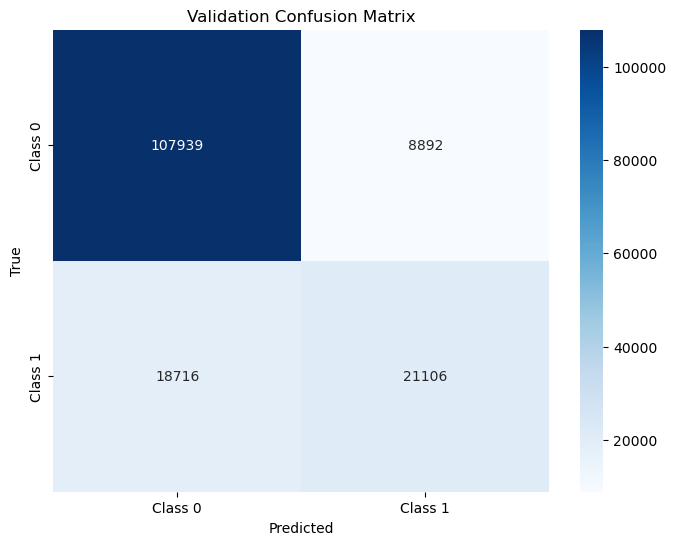

Test Confusion Matrix - Lasso:


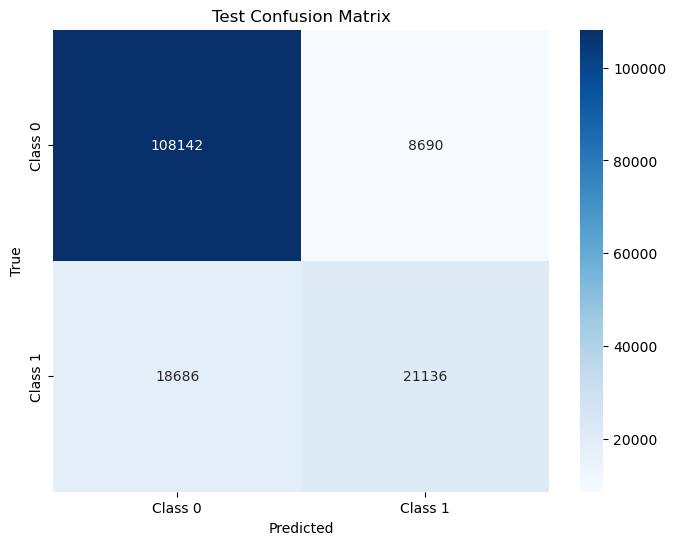

In [29]:
# plot confusion matrices
print("Validation Confusion Matrix - Lasso:")
plot_confusion_matrix(lasso_metrics['Confusion Matrix']['Validation'], 'Validation Confusion Matrix')

print("Test Confusion Matrix - Lasso:")
plot_confusion_matrix(lasso_metrics['Confusion Matrix']['Test'], 'Test Confusion Matrix')

Validation Confusion Matrix - Ridge:


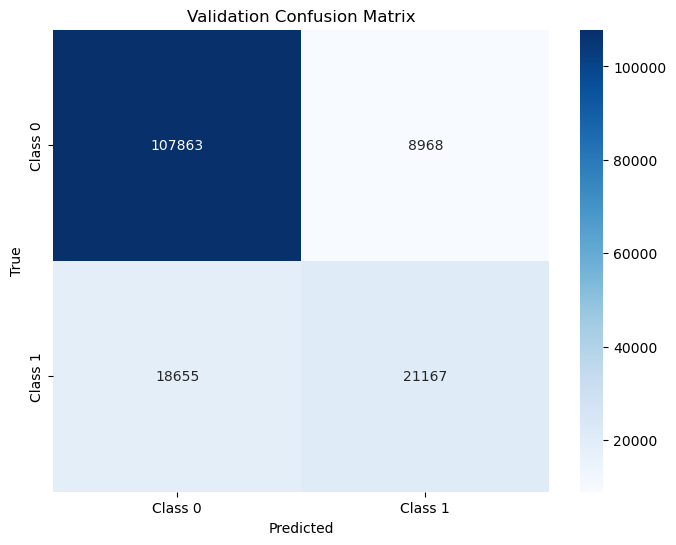

Test Confusion Matrix - Ridge:


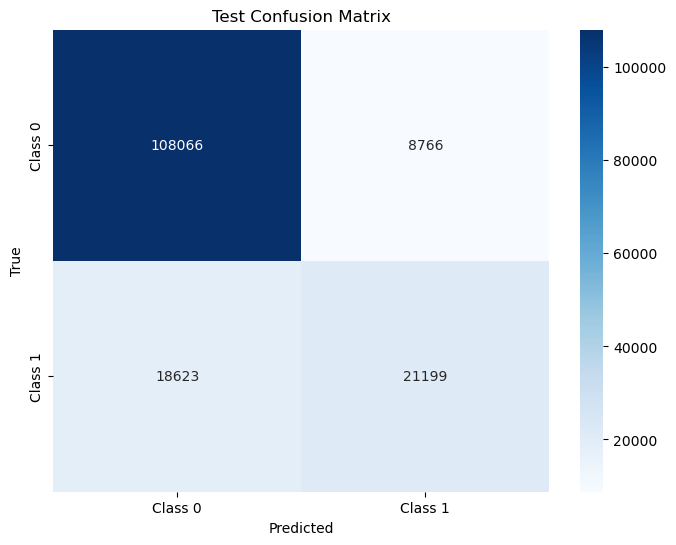

In [30]:
# plot confusion matrices
print("Validation Confusion Matrix - Ridge:")
plot_confusion_matrix(ridge_metrics['Confusion Matrix']['Validation'], 'Validation Confusion Matrix')

print("Test Confusion Matrix - Ridge:")
plot_confusion_matrix(ridge_metrics['Confusion Matrix']['Test'], 'Test Confusion Matrix')

The best hyperparameters for the Ridge and Lasso Models were the default. The test accuracy was 83% for both untuned and tuned Ridge and Lasso models.

In [32]:
# save tuned ridge and lasso models
ridge_best_model_path = 'Models/ridge_best_model.pkl'
lasso_best_model_path = 'Models/lasso_best_model.pkl'
#logreg_best_model_path = 'Models/logreg_best_model.pkl'

joblib.dump(best_ridge_model, ridge_best_model_path)
joblib.dump(best_lasso_model, lasso_best_model_path)
#joblib.dump(logreg_model, logreg_best_model_path)

print(f'Tuned Ridge model saved at: {ridge_best_model_path}')
print(f'Tuned Lasso model saved at: {lasso_best_model_path}')
#print(f'Tuned Logreg model saved at: {logreg_best_model_path}')

Tuned Ridge model saved at: Models/ridge_best_model.pkl
Tuned Lasso model saved at: Models/lasso_best_model.pkl


### Bagging Classifier


The default parameters for baggingClassifier with n_estimators of 10 resulted in a mean accuracy of 0.91 - this is with CV of 5.

In [33]:
# Initialize model
bag_mod = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42)


# Perform cross-validation
scores = cross_val_score(bag_mod, x_train_scaled_pca, y_train, cv=5)

# Print results
print(f"Bagging Classifier Accuracy for each fold: {scores}")
print(f"Mean accuracy: {scores.mean():.2f}")

Bagging Classifier Accuracy for each fold: [0.9008781  0.90497742 0.91157077 0.90938813 0.91038774]
Mean accuracy: 0.91


In [34]:
params = bag_mod.get_params()
print("Parameters used by the Bagging Classifier:")
print(params)

Parameters used by the Bagging Classifier:
{'bootstrap': True, 'bootstrap_features': False, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__monotonic_cst': None, 'estimator__random_state': None, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(), 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Originally, there were more features and options that were on the grid, but it would've taken 40 hours to run (Fitting 5 folds for each of 972 candidates, totalling 4860 fits). So a reduced parameter grid and the use of RandomizedSearchCV were employed to run the hypertuning.

In [37]:
param_grid = {
    'n_estimators': [10, 20],                    # Fewer values
    'max_samples': [0.5, 1.0],                   # Reduced options
    'max_features': [0.5, 1.0],                  # Reduced options
    'bootstrap': [True],                         # Reduced options
    'bootstrap_features': [False],               # Reduced options
    'estimator__max_depth': [None, 10],          # Fewer values
    'estimator__min_samples_split': [2, 5],      # Fewer values
    # Remove 'n_jobs' from parameter grid
}

bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42)

# Using RandomizedSearchCV with fewer iterations to cut down on tuning time
random_search = RandomizedSearchCV(estimator=bagging_clf, param_distributions=param_grid, 
                                     n_iter=10, cv=5, n_jobs=-1, verbose=2, random_state=42)

# Perform the search
random_search.fit(x_train_scaled_pca, y_train)

# Get the best parameters and results
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best Cross-Validation Score:{random_search.best_score_:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found: {'n_estimators': 20, 'max_samples': 1.0, 'max_features': 1.0, 'estimator__min_samples_split': 5, 'estimator__max_depth': None, 'bootstrap_features': False, 'bootstrap': True}
Best Cross-Validation Score:0.9125


The hypertuned parameter ended up having the same mean accuracy score as the default model.

In [38]:
# Get best estimator for the baggingclassifier
best_bag_model = random_search.best_estimator_

# save tuned bagging classifier
bag_best_model_path = 'Models/bag_best_model.pkl'

joblib.dump(best_bag_model, bag_best_model_path)

print(f'Tuned bagging model saved at: {bag_best_model_path}')

Tuned bagging model saved at: Models/bag_best_model.pkl


In [39]:
bag_metrics = evaluate_model(best_bag_model, x_val_scaled_pca, y_val, x_test_scaled_pca, y_test, x_train_scaled_pca, y_train)

# convert to df
bag_metrics_df = metrics_to_dataframe(bag_metrics)

[CV] END bootstrap=True, bootstrap_features=False, estimator__max_depth=10, estimator__min_samples_split=5, max_features=1.0, max_samples=0.5, n_estimators=20; total time=  45.9s
[CV] END bootstrap=True, bootstrap_features=False, estimator__max_depth=None, estimator__min_samples_split=5, max_features=1.0, max_samples=1.0, n_estimators=20; total time= 2.0min
[CV] END bootstrap=True, bootstrap_features=False, estimator__max_depth=10, estimator__min_samples_split=5, max_features=1.0, max_samples=1.0, n_estimators=10; total time=  43.3s
[CV] END bootstrap=True, bootstrap_features=False, estimator__max_depth=10, estimator__min_samples_split=5, max_features=0.5, max_samples=0.5, n_estimators=20; total time=  28.8s
[CV] END bootstrap=True, bootstrap_features=False, estimator__max_depth=None, estimator__min_samples_split=5, max_features=1.0, max_samples=0.5, n_estimators=10; total time=  36.7s
[CV] END bootstrap=True, bootstrap_features=False, estimator__max_depth=10, estimator__min_samples_sp

In [40]:
print("Bagging Classification Evaluation Metrics:")
bag_metrics_df

Bagging Classification Evaluation Metrics:


Type,Metric,CV,Test,Validation
0,Accuracy,0.910117,0.902524,0.902255
1,Classification Report,NaN,"{'0': {'precision': 0.9691952323754967, 'recal...","{'0': {'precision': 0.9690702595806419, 'recal..."
2,Confusion Matrix,NaN,"[[104896, 11936], [3334, 36488]]","[[104866, 11965], [3347, 36475]]"
3,F1-Score,NaN,0.826961,0.826517
4,Kappa,0.820235,0.760007,0.759376
5,MCC,0.820666,0.767049,0.766437
6,PR-AUC,0.961586,0.902817,0.903039
7,Precision,NaN,0.753511,0.752993
8,ROC-AUC,0.968425,0.967614,0.967611
9,Recall,NaN,0.916277,0.915951


Validation Confusion Matrix - Bagging Classifier:


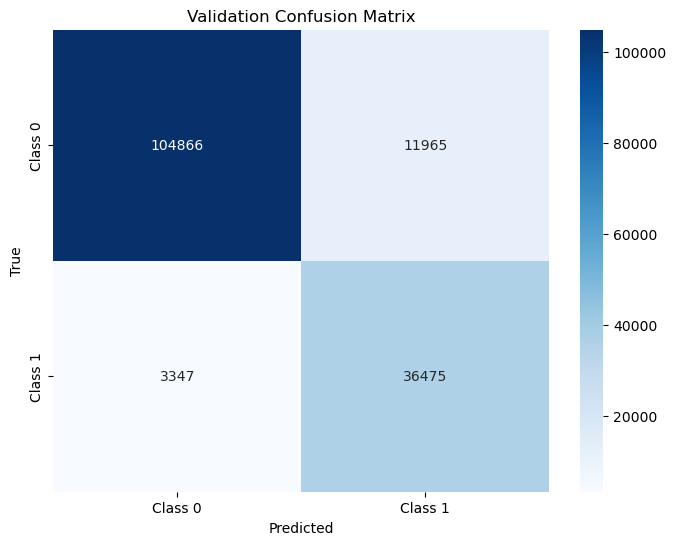

Test Confusion Matrix - Bagging Classifier:


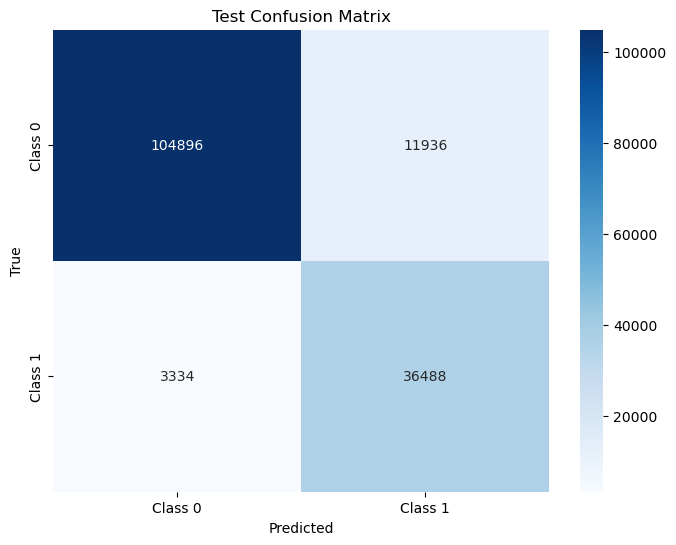

In [41]:
# plot confusion matrices
print("Validation Confusion Matrix - Bagging Classifier:")
plot_confusion_matrix(bag_metrics['Confusion Matrix']['Validation'], 'Validation Confusion Matrix')

print("Test Confusion Matrix - Bagging Classifier:")
plot_confusion_matrix(bag_metrics['Confusion Matrix']['Test'], 'Test Confusion Matrix')

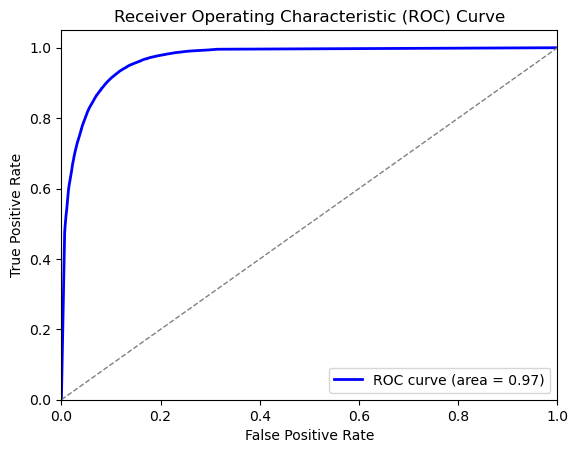

AUC: 0.97


In [42]:
# Predict probabilities for the test set
y_probs = best_bag_model.predict_proba(x_test_scaled_pca)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)  # Adjust if y_test is binarized

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print AUC value
print(f"AUC: {roc_auc:0.2f}")

In [ ]:
# retrieve saved models 


In [ ]:
# Initialize models
models = {
    'Bagging Classifier': best_bag_model,
    'Logistic Regression': logreg_model,
    'Ridge Regression': best_ridge_model,
    'Lasso regression' : best_lasso_model, 
    'XGBoost': best_model_xgb, 
    'Neural Network': best_model_nn, 
    'Quadratic Discriminat Analysis': best_model_qda, 
    'AdaBoost': best_model_ada
}

# Fit models and compute ROC curves
plt.figure()

for name, model in models.items():
    model.fit(x_train_scaled_pca, y_train)
    y_probs = model.predict_proba(x_test_scaled_pca)[:, 1]  # Probabilities for the positive class

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:0.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Since we have 3 principal components, a 3d graph was rendered.

#### *PCA components explained*

Let's see how much of each feature influenced the principal components.


In [ ]:
pca_scaled = PCA(n_components=3)
new_X_train_scaled_pca = pca_scaled.fit_transform(x_train_scaled)
components = pca_scaled.components_
evr = pca_scaled.explained_variance_ratio_

loadings_scaled = pd.DataFrame(components.T, columns=[f'PC{i+1}' for i in range(components.shape[0])], index=[x_train_scaled.columns])
# Sort each column in ascending order
sorted_loadings_scaled = loadings_scaled.apply(lambda x: x.sort_values())

print("\nSorted Loadings Scaled:")
print(sorted_loadings_scaled)

# Print sorted values for each PC individually
for i in range(components.shape[0]):
    sorted_pc = loadings_scaled[f'PC{i+1}'].sort_values(ascending=True)
    print(f"\nSorted Loadings for PC{i+1}:")
    print(sorted_pc)

In [ ]:
# Sort and select top 20 features for each component, can change if needed
top_features_per_pc = {}
num_top_features = 20

for pc in loadings_scaled.columns:
    top_features = loadings_scaled[pc].abs().sort_values(ascending=False).head(num_top_features).index
    top_features_per_pc[pc] = top_features

# Get unique top features
unique_top_features = list(set([feature for features in top_features_per_pc.values() for feature in features]))

# Filter DataFrame to include only top features
loadings_scaled_top = loadings_scaled.loc[unique_top_features]

# Perform hierarchical clustering on top features
Z = linkage(loadings_scaled_top, 'ward')

# Plot clustered heatmap
sns.clustermap(loadings_scaled_top, annot=True, cmap='coolwarm', linewidths=0.5, figsize=(20, 15), row_cluster=True, col_cluster=False)
plt.title('Heatmap of Top Feature Contributions to Principal Components with Clustering')
plt.show()

According to this visualization, within the top 20 features, the 6 that stand out are total payment, number of users, number of providers, average number of providers per county, number of fee for service benficiaries and average number of users per provider.